**For the analysis of the hypothesis click [here](#Statistical-Analysis-of-Data-on-Pull-Request-Governance-Models-in-FOSS-Commununities)**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

from theano.compile.ops import as_op
from scipy.stats import norm
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from IPython.display import Image
import seaborn as sns
import pymc3 as pm
import numpy as np
from scipy.stats import norm
import pandas as pd

import theano.tensor as T
from theano.compile.ops import as_op

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':14}

## Loading dataset

In [10]:
## Loading data
df2 = pd.read_csv('../data/pseudonymized-data.csv', 
                  dtype={'Community':'category',
                               'V27':'category',
                               'V28':'category',
                               'V29':'category',
                               'V30':'category',
                               'V31':'category',
                               'V32':'category',
                               'V33':'category'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Community  387 non-null    category
 1   V27        387 non-null    category
 2   V28        387 non-null    category
 3   V29        387 non-null    category
 4   V30        387 non-null    category
 5   V31        387 non-null    category
 6   V32        387 non-null    category
 7   V33        387 non-null    category
dtypes: category(8)
memory usage: 5.3 KB


## Auxiliary functions

TODO[RAUL]: Add an English version explanation of these functions

In [19]:
# Auxiliary functions

########################
## Index manipulation ##
########################

# reduce data values by 1 so that they become indexes for the cdf array below.
# the .cat.codes function from pandas doesn't work because it assings codes depending on the different values of the data
def from_data_to_code(x):
    return int(x)-1

def codes(self):
    return np.array([from_data_to_code(x) for x in self])

def count_per_data_value(d,c,q):
    return np.array([ len(d[(d[q] == x) & (d.Community==c)][q]) for x in ['1','2','3','4','5']])

def comm_to_code(d,c):
    return [code for (comm,code) in zip(d.Community.unique(),d.Community.cat.codes.unique()) if comm==c][0]


########################
## Plotting functions ##
########################

# Countplot without -1s
def plot_count(q):
    plt.figure(figsize=(30,10))
    sns.countplot(x=df2[df2[q]!='-1'].Community,hue=df2[df2[q]!='-1'][q])
    plt.suptitle('Data for question '+q)
    plt.show()

# Mean density plots of answers to variable v for all communities
def mean_densities(t,v):
    plt.figure(figsize=(15,5))
    NUM_COLORS = 16
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in np.linspace(0, 1, NUM_COLORS)]
    grp_idxs_colors_grp_names = zip(df2.Community.cat.codes.unique(),colors,df2.Community.unique())
    [pm.plot_kde(t['mu'][:,i], 
                 plot_kwargs={'color': c}, cumulative=False, 
                 label=n) 
      for (i,c,n) in grp_idxs_colors_grp_names]
    plt.xlim([0,7])
    plt.legend(loc='best')
    plt.suptitle('Mean density plots for '+v)
    plt.show()

# Posterior predictive check: plotting several draws of inferred normal and mean normal
def plot_ppc_normal_density(d,t,c,q):
    c_code=comm_to_code(d,c)
    x=np.arange(-5,10,step=.01)
    s=pd.Series((count_per_data_value(df2,c,q)/count_per_data_value(df2,c,q).sum()))
    s.index=s.index+1
    s.plot.bar(rot=0, color='royalblue')
    plt.suptitle('Data of '+c+' question '+q)
    [plt.plot(x,norm(loc=m,scale=s).pdf(x),color='lightblue',alpha=.05) 
        for (m,s) in zip(t['mu'][18000:,c_code],t['sigma'][18000:,  c_code])]
    plt.plot(x,norm(loc=np.mean(t['mu'][:,c_code]),scale=np.mean(t['sigma'][:,c_code])).pdf(x),color='blue',linewidth=2)
    plt.xlim([-1,7])
    plt.show()

# Posterior predictive check: plotting data bars together with cdf and HDI
def ppc_count_cdfs(trace2,df2,com1,q):
    mu2 = trace2['mu']
    sigma2 = trace2['sigma']
    code_com1 = comm_to_code(df2,com1)
    
    # Concatenate the fixed thresholds into the estimated thresholds
    n = trace2['theta_missing'].shape[0]
    thresholds2 = np.c_[np.tile([1.5], (n,1)),
                        trace2['theta_missing'],
                        np.tile([4.5], (n,1))]

    fig, ax1 = plt.subplots(1, figsize=(10,4))

    # Posterior predictive probabilities of the outcomes
    threshCumProb2A = np.empty(thresholds2.shape)
    for i in np.arange(threshCumProb2A.shape[0]):
        threshCumProb2A[i] = norm().cdf((thresholds2[i] - mu2[i,code_com1])/sigma2[i,code_com1])    
    outProb2A = (np.c_[threshCumProb2A, np.tile(1, (thresholds2.shape[0],1))]
           - np.c_[np.tile(0, (thresholds2.shape[0],1)), threshCumProb2A])
    yerr2A = np.abs(np.subtract(pm.hpd(outProb2A), outProb2A.mean(axis=0).reshape(-1,1)))

    ax1.errorbar(x = np.arange(outProb2A.shape[1]), y=outProb2A.mean(axis=0),
                 yerr=yerr2A.T, color='darkblue', fmt='o', capthick=3)

    # Count bars from the data
    pd.Series((count_per_data_value(df2,com1,q)/count_per_data_value(df2,com1,q).sum())).plot.bar(ax=ax1, rot=0, color='royalblue')
    ax1.set_title('Data for {0} with Post. Pred.\nN = {1}'.format(com1, df2[(df2.Community == com1) & (df2[q]!='-1') ][q].size))#, fontdict=f_dict)
    ax1.set_xlabel('y')
#     sns.despine(ax=ax1, left=True)
    ax1.yaxis.set_visible(False)

    plt.show()
    
# Comparison of two communities code (original code from XXX)
def com(trace2,df2,com1,com2,q):
    mu2 = trace2['mu']
    sigma2 = trace2['sigma']
    code_com1 = comm_to_code(df2,com1)
    code_com2 = comm_to_code(df2,com2)
    
    # Concatenate the fixed thresholds into the estimated thresholds
    n = trace2['theta_missing'].shape[0]
    thresholds2 = np.c_[np.tile([1.5], (n,1)),
                        trace2['theta_missing'],
                        np.tile([4.5], (n,1))]

    fig, axes = plt.subplots(5,2, figsize=(10,14))
    ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10 = axes.flatten() 

    # Mu
    pm.plot_posterior(mu2[:,code_com1], point_estimate='mode', color=color, ax=ax1)
    ax1.set_xlabel('$\mu_{1}$', fontdict=f_dict)
    pm.plot_posterior(mu2[:,code_com2], point_estimate='mode', color=color, ax=ax3)
    ax3.set_xlabel('$\mu_{2}$', fontdict=f_dict)
    for title, ax in zip([com1, com2], [ax1, ax3]):
        ax.set_title(title, fontdict=f_dict)

    # Sigma
    pm.plot_posterior(sigma2[:,code_com1], point_estimate='mode', color=color, ax=ax5)
    ax5.set_xlabel('$\sigma_{1}$', fontdict=f_dict)
    pm.plot_posterior(sigma2[:,code_com2], point_estimate='mode', color=color, ax=ax7)
    ax7.set_xlabel('$\sigma_{2}$', fontdict=f_dict)
    for title, ax in zip([com1+' Std. Dev.', com2+' Std. Dev.'], [ax5, ax7]):
        ax.set_title(title, fontdict=f_dict)

    # Posterior distribution on the thresholds
    ax9.scatter(thresholds2, np.tile(thresholds2.mean(axis=1).reshape(-1,1), (1,4)), color=color, alpha=.6, facecolor='none')
    ax9.set_ylabel('Mean Threshold', fontdict=f_dict)
    ax9.set_xlabel('Threshold', fontdict=f_dict)
    ax9.vlines(x = thresholds2.mean(axis=0),
               ymin=thresholds2.mean(axis=1).min(),
               ymax=thresholds2.mean(axis=1).max(), linestyles='dotted', colors=color)

    # Posterior predictive probabilities of the outcomes
    threshCumProb2A = np.empty(thresholds2.shape)
    for i in np.arange(threshCumProb2A.shape[0]):
        threshCumProb2A[i] = norm().cdf((thresholds2[i] - mu2[i,code_com1])/sigma2[i,code_com1])    
    outProb2A = (np.c_[threshCumProb2A, np.tile(1, (thresholds2.shape[0],1))]
           - np.c_[np.tile(0, (thresholds2.shape[0],1)), threshCumProb2A])
    yerr2A = np.abs(np.subtract(pm.hpd(outProb2A), outProb2A.mean(axis=0).reshape(-1,1)))

    ax2.errorbar(x = np.arange(outProb2A.shape[1]), y=outProb2A.mean(axis=0),
                 yerr=yerr2A.T, color=color, fmt='o')

    threshCumProb2B = np.empty(thresholds2.shape)
    for i in np.arange(threshCumProb2B.shape[0]):
        threshCumProb2B[i] = norm().cdf((thresholds2[i] - mu2[i,code_com2])/sigma2[i,code_com2])    
    outProb2B = (np.c_[threshCumProb2B, np.tile(1, (thresholds2.shape[0],1))]
               - np.c_[np.tile(0, (thresholds2.shape[0],1)), threshCumProb2B])
    yerr2B = np.abs(np.subtract(pm.hpd(outProb2B), outProb2B.mean(axis=0).reshape(-1,1)))

    ax4.errorbar(x = np.arange(outProb2B.shape[1]), y=outProb2B.mean(axis=0),
             yerr=yerr2B.T, color=color, fmt='o')

    for grp, ax in zip([com1, com2], [ax2, ax4]):
        pd.Series((count_per_data_value(df2,grp,q)/count_per_data_value(df2,grp,q).sum())).plot.bar(ax=ax, rot=0, color='royalblue')
        ax.set_title('Data for {0} with Post. Pred.\nN = {1}'.format(grp, df2[(df2.Community == grp) & (df2[q]!='-1') ][q].size), fontdict=f_dict)
        ax.set_xlabel('y')
        sns.despine(ax=ax, left=True)
        ax.yaxis.set_visible(False)

    # Mu diff
    pm.plot_posterior(mu2[:,code_com2]-mu2[:,code_com1], point_estimate='mode', color=color, ax=ax6)
    ax6.set_xlabel('$\mu_{2}-\mu_{1}$', fontdict=f_dict)
    # Sigma diff
    pm.plot_posterior(sigma2[:,code_com2]-sigma2[:,code_com1], point_estimate='mode', color=color, ax=ax8)
    ax8.set_xlabel('$\sigma_{2}-\sigma_{1}$', fontdict=f_dict)
    # Effect size
    pm.plot_posterior((mu2[:,code_com2]-mu2[:,code_com1]) / np.sqrt((sigma2[:,code_com1]**2+sigma2[:,code_com2]**2)/2), point_estimate='mode', color=color, ax=ax10)
    ax10.set_xlabel(r'$\frac{(\mu_2-\mu_1)}{\sqrt{(\sigma_1^2+\sigma_2^2)/2}}$', fontdict=f_dict)
    for title, ax in zip(['Differences of Means', 'Difference of Std. Dev\'s', 'Effect Size'], [ax6, ax8, ax10]):
        ax.set_title(title, fontdict=f_dict)

    fig.suptitle(q, fontsize=16)
    fig.tight_layout()

## Plotting raw data

This is just for presentation purposes.
TODO[RAUL]: Remove the -1s from the legends.

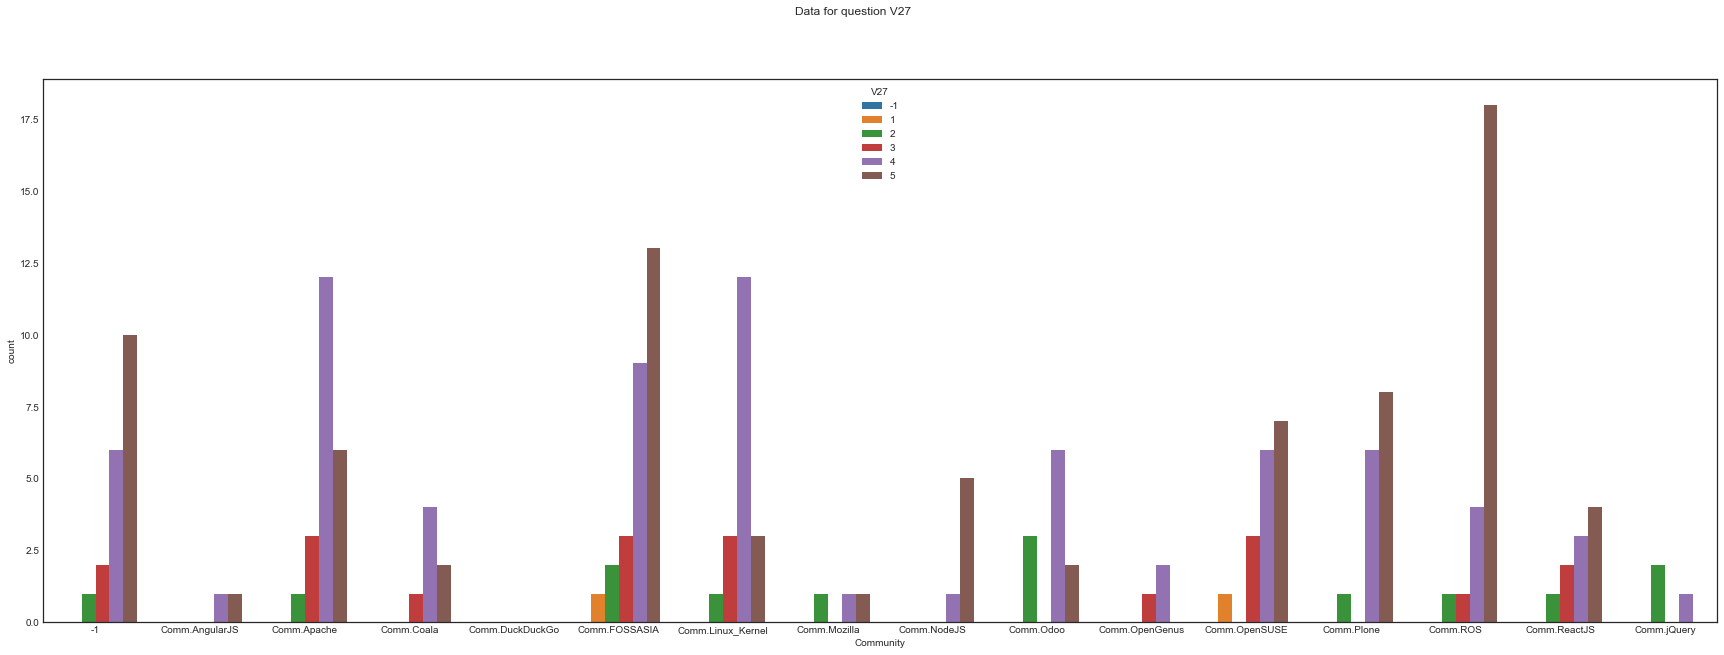

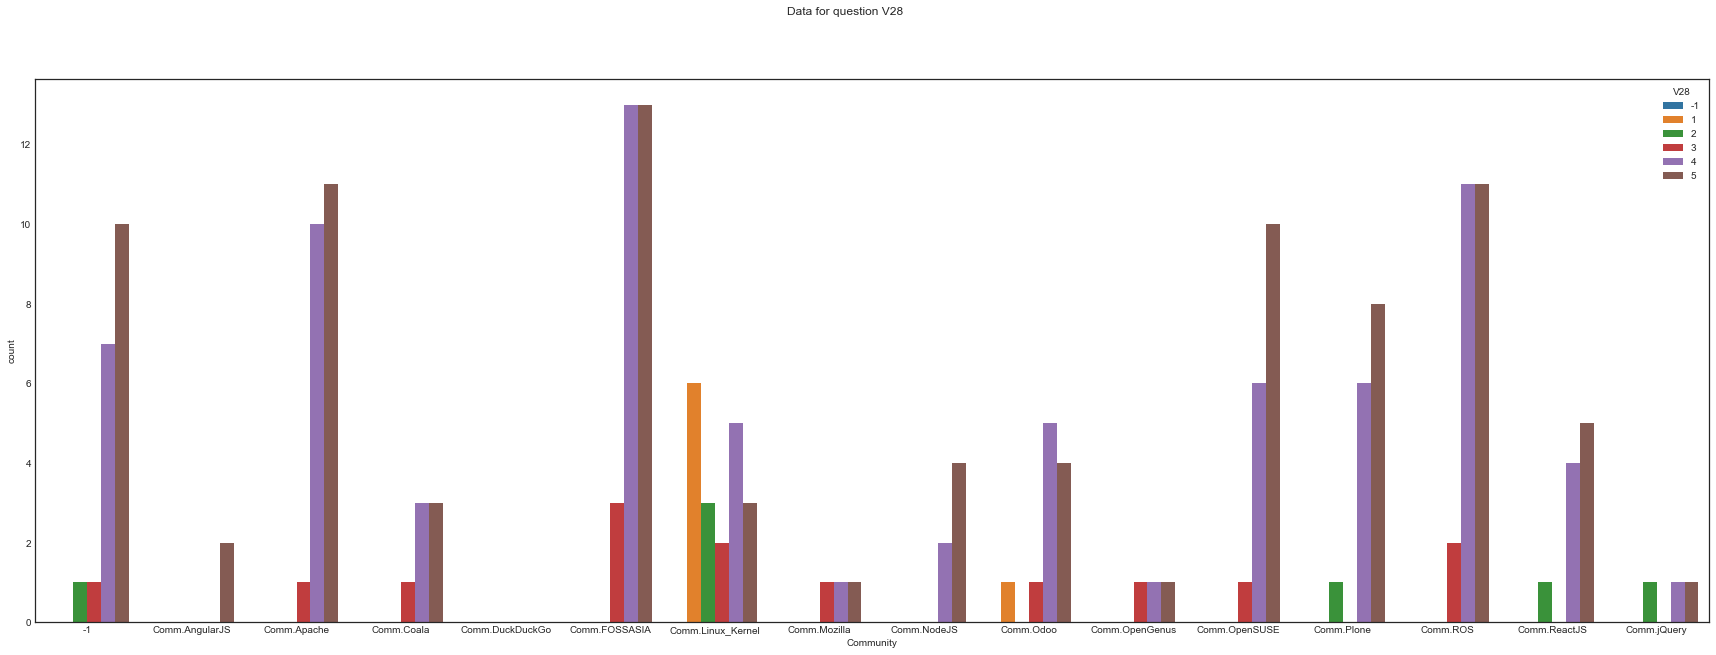

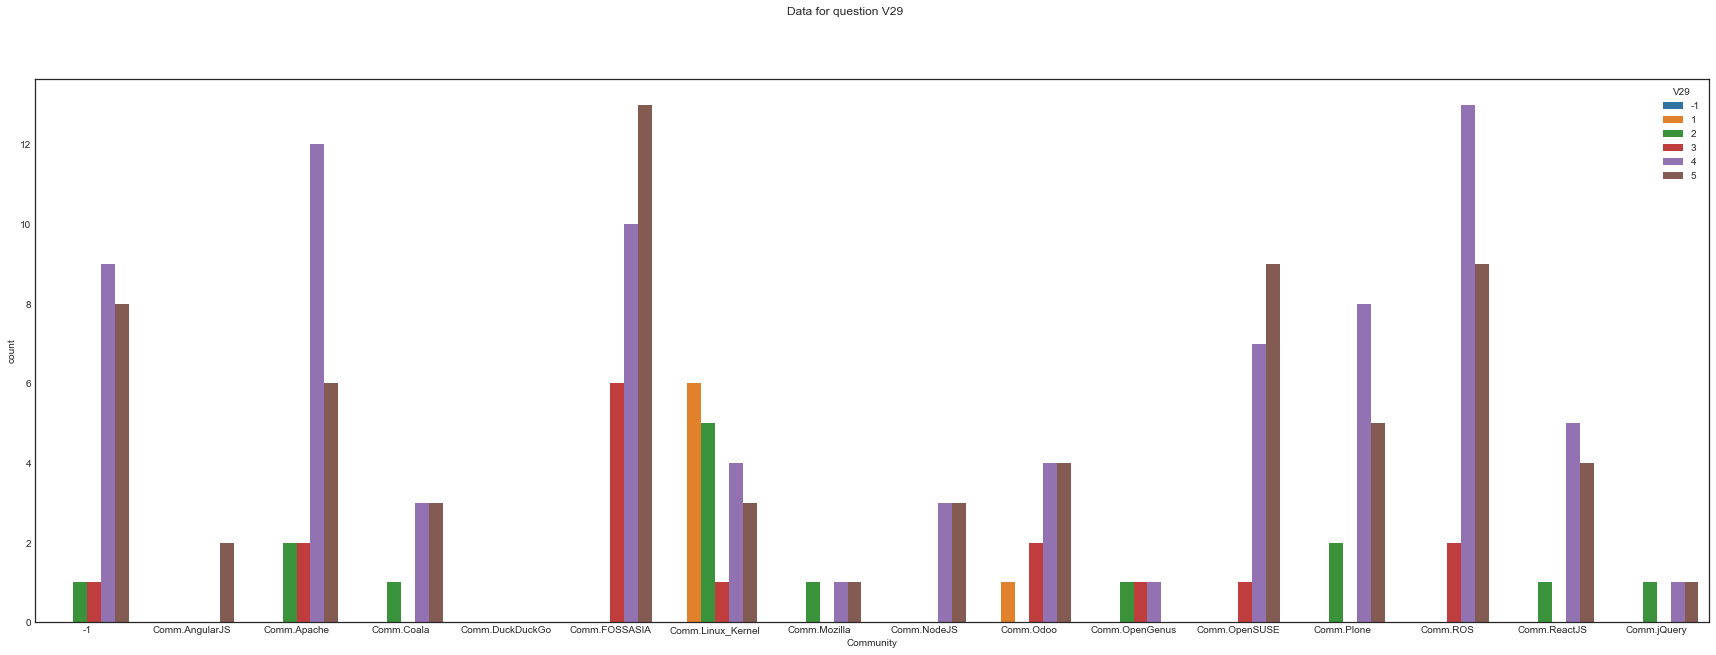

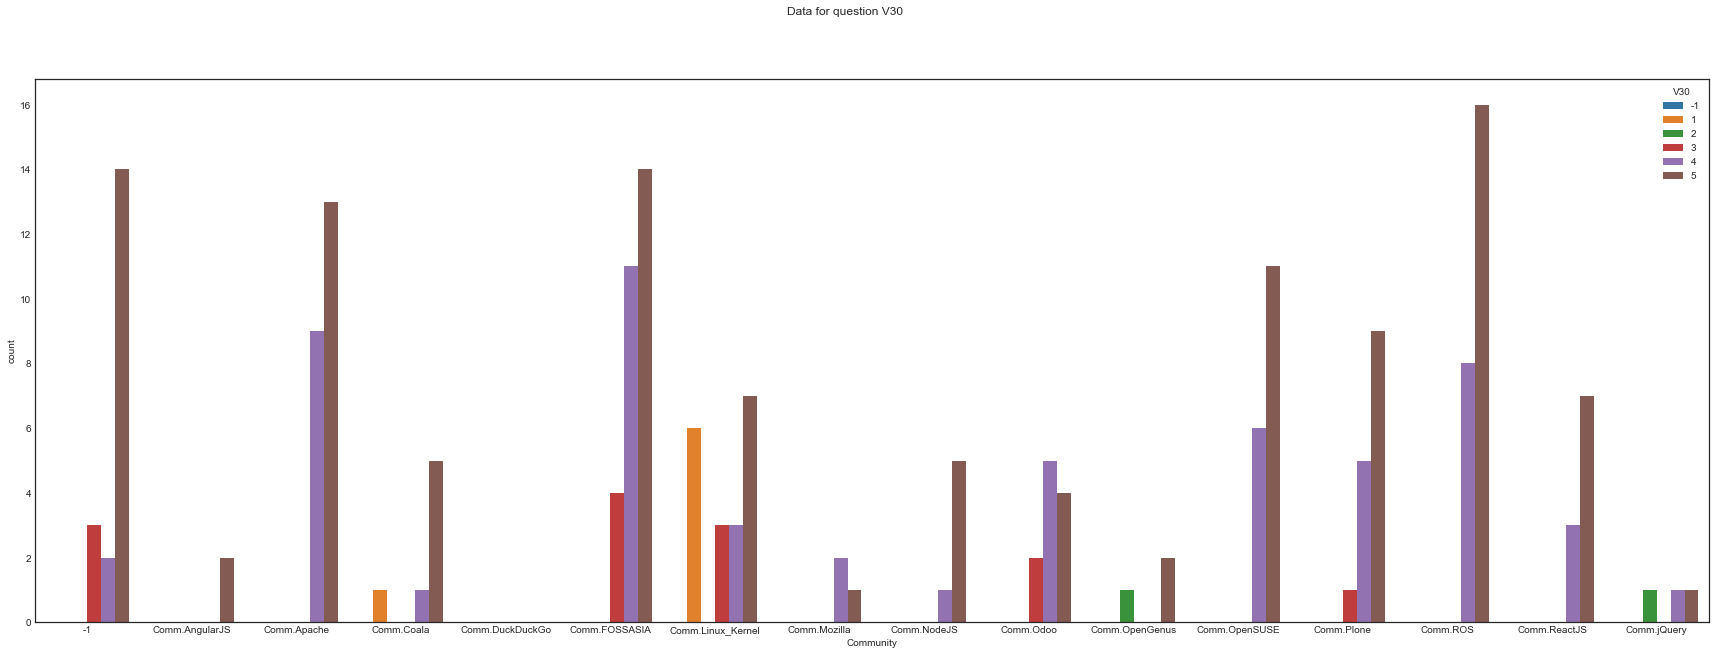

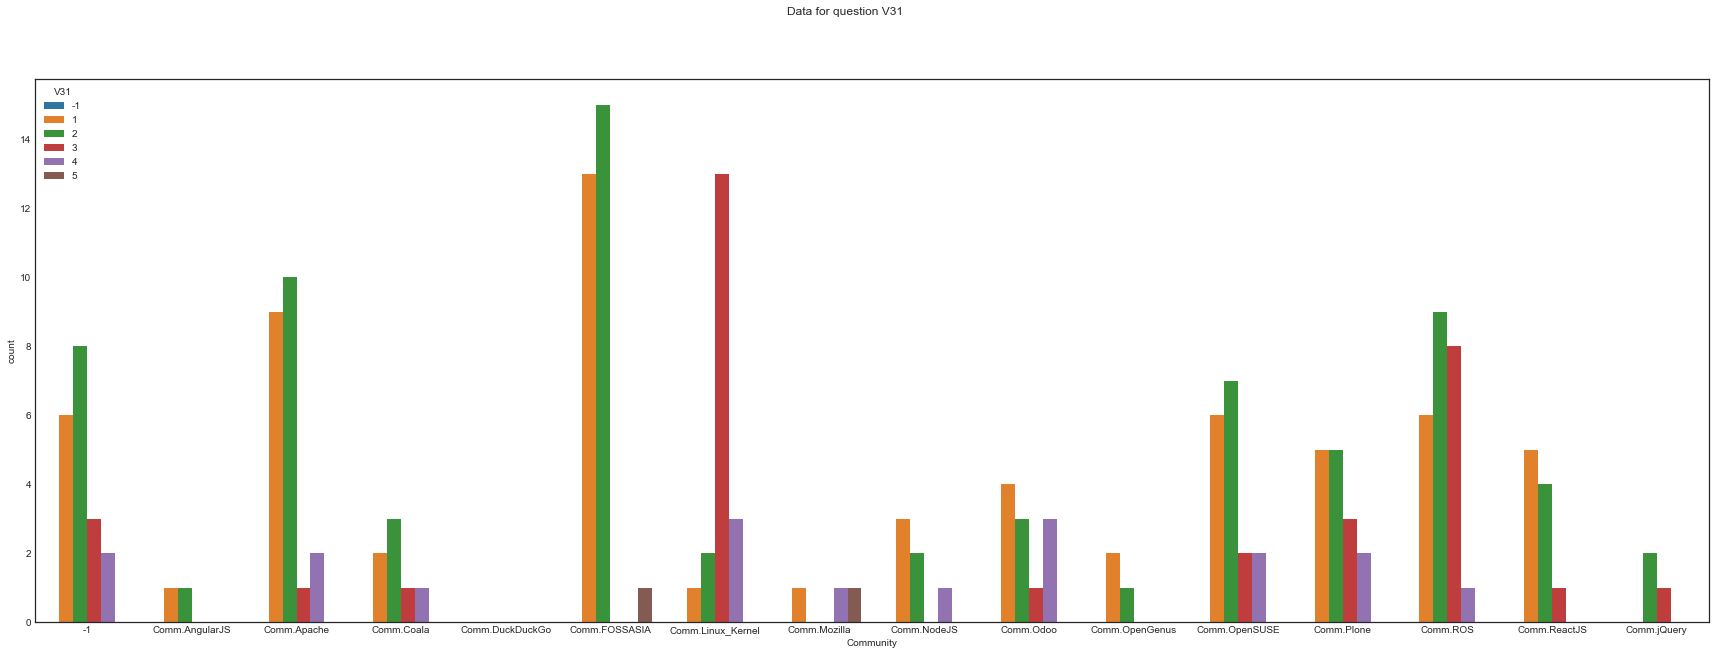

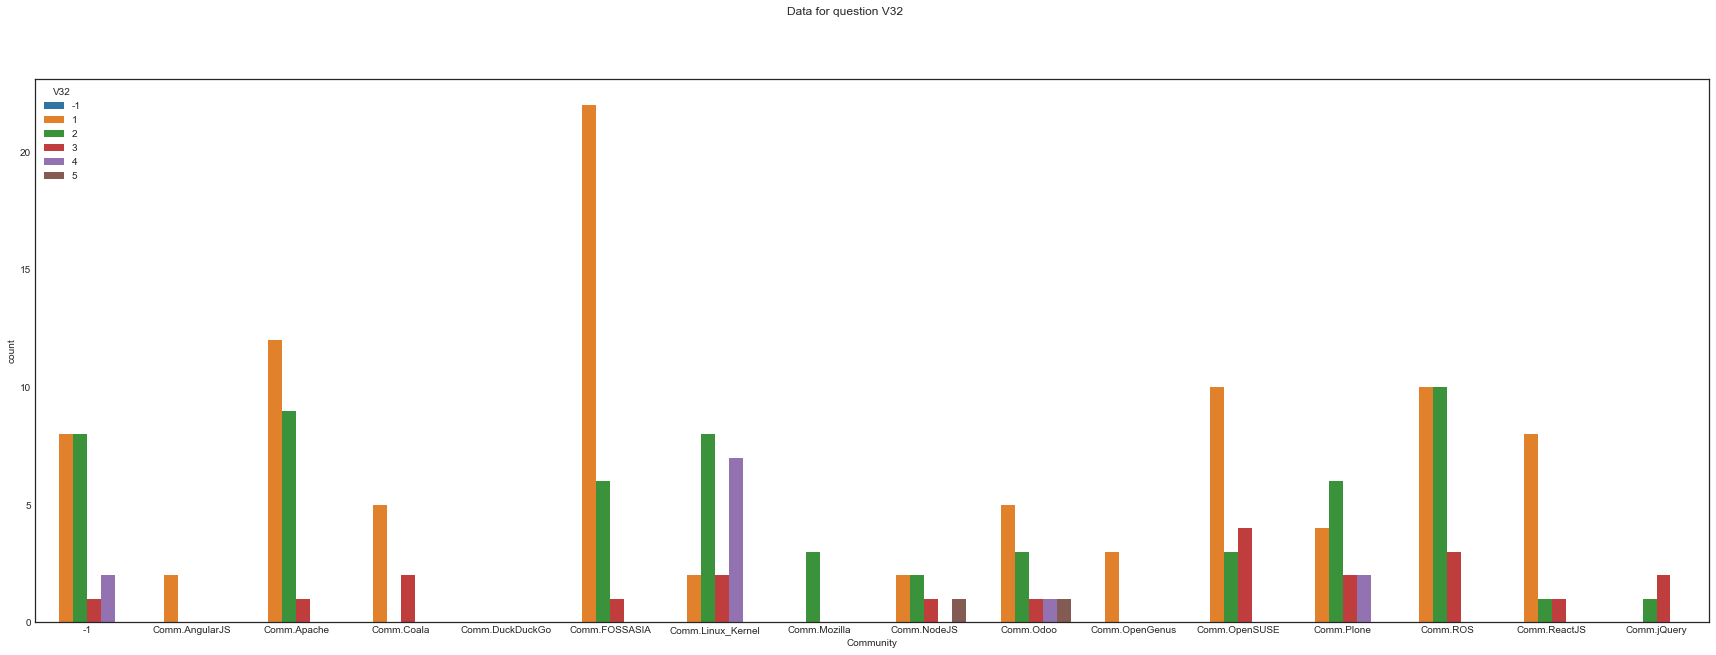

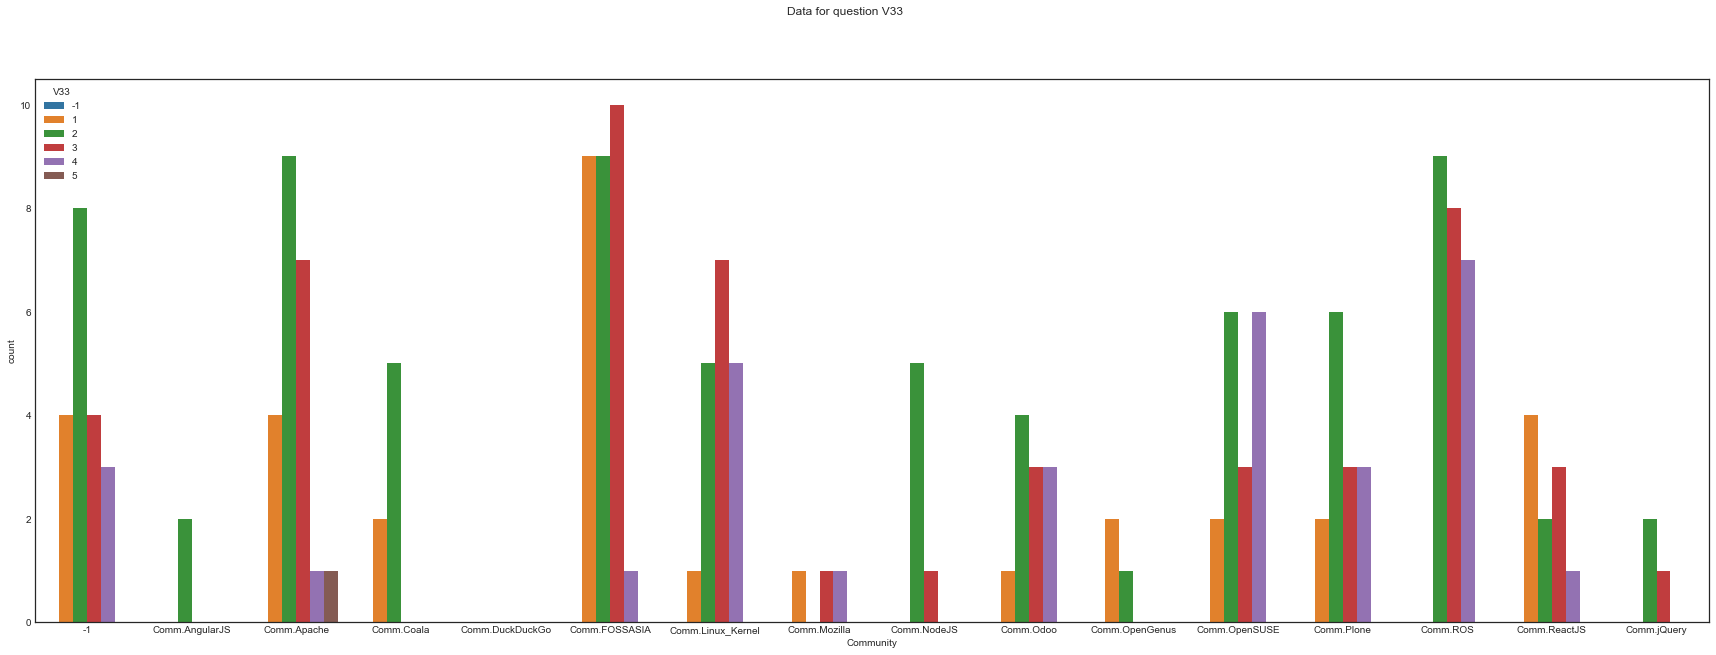

[None, None, None, None, None, None, None]

In [4]:
# Plotting countplots of the raw data
[plot_count(q) for q in ['V27','V28','V29','V30','V31','V32','V33']]

## Inference function

In [26]:
## Inference function

def infer(q,num_samples=5000,tuning=1000,chains=4):
    # Number of outcomes
    nYlevels2 = 5
    # Number of groups
    n_grps = df2.Community.nunique()
    # Group index
    grp_idx = df2[df2[q]!='-1'].Community.cat.codes.values

    thresh2 = np.arange(1.5, nYlevels2, dtype=np.float64)
    thresh_obs2 = np.ma.asarray(thresh2)
    thresh_obs2[1:-1] = np.ma.masked

    print('thresh2:\t{}'.format(thresh2))
    print('thresh_obs2:\t{}'.format(thresh_obs2))


    @as_op(itypes=[tt.dvector, tt.dvector, tt.dvector], otypes=[tt.dmatrix])
    def outcome_probabilities(theta, mu, sigma):
        out = np.empty((nYlevels2, n_grps), dtype=np.float64)
        n = norm(loc=mu, scale=sigma)       
        out[0,:] = n.cdf(theta[0])        
        out[1,:] = np.max([np.repeat(0,n_grps), n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
        out[2,:] = np.max([np.repeat(0,n_grps), n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
        out[3,:] = np.max([np.repeat(0,n_grps), n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
        out[4,:] = 1 - n.cdf(theta[3])
        return out

    with pm.Model() as ordinal_model_multi_groups:    
        
        theta = pm.Normal('theta', mu=thresh2, tau=np.repeat(.5**2, len(thresh2)),
                          shape=len(thresh2), observed=thresh_obs2)
        
        mu = pm.Normal('mu', mu=nYlevels2/2.0, tau=1.0/(nYlevels2**2), shape=n_grps)
        sigma = pm.Uniform('sigma', nYlevels2/1000.0, nYlevels2*10.0, shape=n_grps)
        
        pr = outcome_probabilities(theta, mu, sigma)
        
        y = pm.Categorical('y', pr[:,grp_idx].T, observed=codes(df2[df2[q]!='-1'][q]))
        
        pm.model_to_graphviz(ordinal_model_multi_groups)
        plt.show()
    
        trace2 = pm.sample(num_samples, tune=tuning, cores=chains)
    
        return trace2

## Question V27

In [12]:
t_v27=infer('V27')

thresh2:	[1.5 2.5 3.5 4.5]
thresh_obs2:	[1.5 -- -- 4.5]


/home/pardo/.local/lib/python3.8/site-packages/pymc3/model.py:1668: ImputationWarning: Data in theta contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [mu]
>Slice: [theta_missing]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 604 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Posterior Predictive Check V27

In [17]:
# [plot_ppc_normal_density(df2,t_v27,c,'V27') for c in df2.Community.unique()]
# plot_ppc_normal_density(df2,t_v27,'Comm.Linux_Kernel','V27')
pm.summary(t_v27)

/home/pardo/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
theta_missing[0]   2.325   0.174   2.007    2.650      0.006    0.004   
theta_missing[1]   2.957   0.159   2.672    3.269      0.006    0.004   
mu[0]              4.782   0.611   3.773    5.892      0.014    0.010   
mu[1]              4.341   4.206  -3.755   12.421      0.076    0.061   
mu[2]              3.961   0.285   3.415    4.487      0.006    0.004   
mu[3]              4.287   0.946   2.826    6.189      0.026    0.021   
mu[4]              3.205   5.002  -6.555   12.332      0.092    0.079   
mu[5]              4.569   0.524   3.723    5.643      0.013    0.010   
mu[6]              3.710   0.262   3.245    4.228      0.006    0.004   
mu[7]              4.503   3.442  -1.838   11.839      0.071    0.061   
mu[8]              7.811   3.632   0.226   14.598      0.079    0.061   
mu[9]              3.619   0.545   2.611    4.637      0.011    0.008   
mu[10]             3.581   1.594   0.767    6.977      0.057    0.047   
mu[11]             4.472   0.737   3.142    5.794      0.025    0.020   
mu[12]             5.180   0.932   3.801    6.926      0.032    0.023   
mu[13]             7.062   1.620   4.662   10.119      0.071    0.050   
mu[14]             4.532   1.099   2.806    6.651      0.031    0.024   
mu[15]             2.947   2.082  -0.721    7.145      0.074    0.064   
sigma[0]           1.868   0.707   0.867    3.093      0.018    0.013   
sigma[1]          17.916  13.662   0.302   43.693      0.306    0.227   
sigma[2]           1.134   0.275   0.679    1.633      0.007    0.005   
sigma[3]           1.839   1.499   0.409    4.093      0.058    0.041   
sigma[4]          26.883  14.384   3.986   49.991      0.259    0.205   
sigma[5]           2.066   0.583   1.105    3.092      0.017    0.012   
sigma[6]           0.976   0.237   0.591    1.432      0.006    0.004   
sigma[7]          11.225  11.053   0.794   35.715      0.384    0.276   
sigma[8]          14.035  13.079   0.190   41.834      0.387    0.274   
sigma[9]           1.596   0.634   0.725    2.638      0.020    0.015   
sigma[10]          2.606   4.090   0.041    7.763      0.188    0.133   
sigma[11]          2.219   0.896   0.980    3.825      0.033    0.025   
sigma[12]          2.189   1.178   0.747    4.307      0.046    0.032   
sigma[13]          3.343   1.601   1.177    6.364      0.071    0.050   
sigma[14]          2.638   1.830   0.758    5.147      0.060    0.042   
sigma[15]          3.942   5.704   0.232   11.707      0.263    0.186   

                  ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
theta_missing[0]     814.0   814.0     804.0    1564.0   1.00  
theta_missing[1]     654.0   651.0     647.0    1264.0   1.00  
mu[0]               1980.0  1897.0    2248.0    1972.0   1.00  
mu[1]               3047.0  2344.0    3045.0    2360.0   1.00  
mu[2]               2159.0  2099.0    2214.0    1954.0   1.00  
mu[3]               1290.0  1024.0    2037.0    1017.0   1.01  
mu[4]               2952.0  2004.0    2956.0    2463.0   1.00  
mu[5]               1525.0  1442.0    1738.0    1469.0   1.00  
mu[6]               2154.0  2092.0    2202.0    2166.0   1.00  
mu[7]               2377.0  1606.0    2491.0    1624.0   1.00  
mu[8]               2113.0  1790.0    2162.0    1793.0   1.00  
mu[9]               2495.0  2194.0    2716.0    1670.0   1.00  
mu[10]               776.0   587.0    1328.0     701.0   1.00  
mu[11]               857.0   688.0    1425.0     835.0   1.00  
mu[12]               841.0   800.0    1099.0     931.0   1.00  
mu[13]               520.0   519.0     578.0     771.0   1.01  
mu[14]              1218.0  1022.0    1662.0    1116.0   1.00  
mu[15]               801.0   531.0    1348.0     671.0   1.00  
sigma[0]            1506.0  1461.0    1752.0    1808.0   1.00  
sigma[1]            1997.0  1817.0    2081.0    1840.0   1.00  
sigma[2]            1445.0  1415.0    1495.0    1591.0   1.00  
sigma[3]             667.0   667.0     894.0     813.0  

### Density plot of mean distributions V27

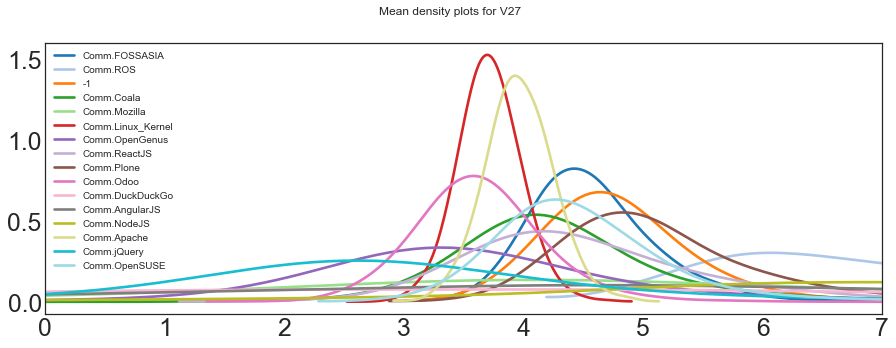

In [13]:
mean_densities(t_v27,'V27')

/home/pardo/.local/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/pardo/.local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


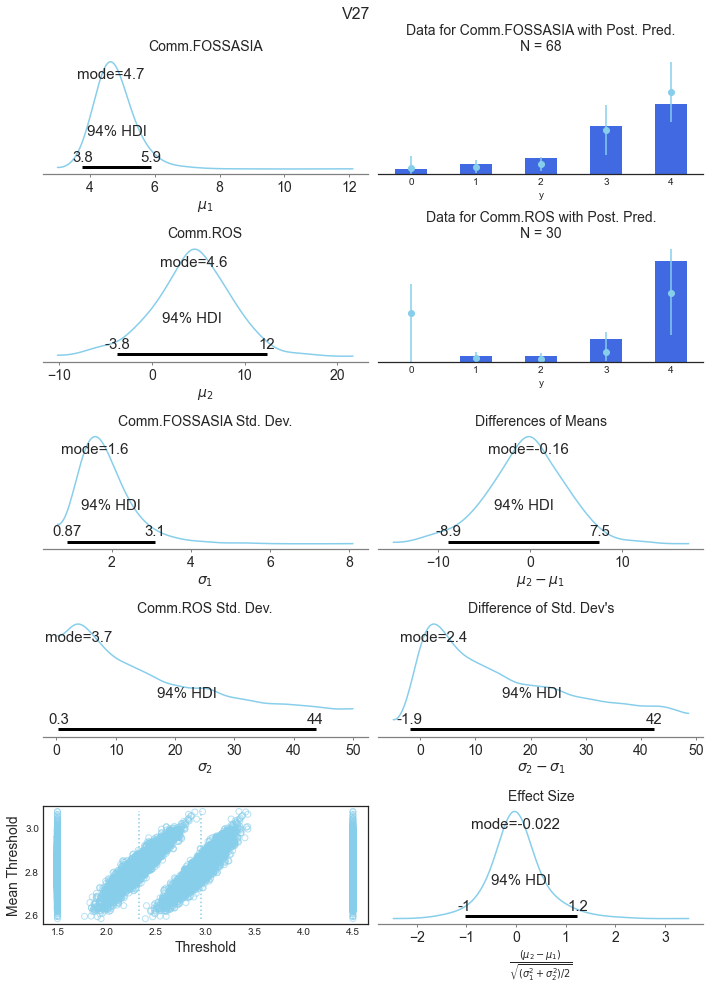

In [15]:
com(t_v27,df2,'Comm.FOSSASIA','Comm.ROS','V27')
# df2.Community.unique()
# n = t_v27['theta_missing'].shape[0]
# thresholds2=np.c_[np.tile([1.5], (n,1)), t_v27['theta_missing'], np.tile([4.5], (n,1))]
# t_v27['theta_missing']
# np.tile(thresholds2.mean(axis=1).reshape(-1,1), (1,4))
# thresholds2.mean(axis=1).reshape(-1,1)

### Diagnosis V27

In [17]:
pm.summary(t_v27)

/home/pardo/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
theta_missing[0]   2.336   0.174   2.018    2.670      0.003    0.002   
theta_missing[1]   2.965   0.161   2.670    3.277      0.003    0.002   
mu[0]              4.780   0.600   3.734    5.886      0.006    0.004   
mu[1]              4.400   4.235  -3.623   12.825      0.034    0.028   
mu[2]              3.961   0.280   3.439    4.494      0.003    0.002   
mu[3]              4.295   0.936   2.735    6.015      0.013    0.011   
mu[4]              3.107   4.948  -6.020   12.391      0.041    0.036   
mu[5]              4.560   0.510   3.683    5.543      0.006    0.005   
mu[6]              3.707   0.259   3.225    4.214      0.002    0.002   
mu[7]              4.319   3.325  -1.827   11.328      0.029    0.024   
mu[8]              7.775   3.557   0.654   14.738      0.036    0.027   
mu[9]              3.626   0.530   2.597    4.596      0.005    0.004   
mu[10]             3.686   1.723   0.970    7.196      0.031    0.027   
mu[11]             4.465   0.742   3.209    5.814      0.010    0.008   
mu[12]             5.127   0.932   3.774    6.877      0.016    0.012   
mu[13]             7.187   1.793   4.685   10.609      0.041    0.030   
mu[14]             4.533   1.156   2.789    6.641      0.019    0.016   
mu[15]             2.918   1.987  -0.488    7.164      0.030    0.026   
sigma[0]           1.865   0.691   0.875    3.104      0.008    0.006   
sigma[1]          18.280  13.995   0.303   44.549      0.143    0.104   
sigma[2]           1.130   0.279   0.687    1.662      0.003    0.002   
sigma[3]           1.801   1.415   0.464    3.967      0.024    0.017   
sigma[4]          26.834  14.348   4.062   50.000      0.112    0.085   
sigma[5]           2.051   0.579   1.151    3.132      0.008    0.006   
sigma[6]           0.963   0.236   0.585    1.415      0.003    0.002   
sigma[7]          11.123  10.833   0.662   34.518      0.141    0.099   
sigma[8]          13.505  13.084   0.222   41.916      0.182    0.128   
sigma[9]           1.562   0.564   0.749    2.589      0.007    0.005   
sigma[10]          2.716   4.423   0.030    8.599      0.088    0.062   
sigma[11]          2.222   0.941   0.965    3.814      0.015    0.011   
sigma[12]          2.110   1.162   0.733    4.072      0.021    0.015   
sigma[13]          3.491   1.842   1.109    6.835      0.042    0.030   
sigma[14]          2.543   1.611   0.813    5.068      0.029    0.022   
sigma[15]          3.689   5.111   0.252   11.165      0.094    0.066   

                  ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
theta_missing[0]    3724.0   3715.0    3741.0    6969.0    1.0  
theta_missing[1]    3421.0   3406.0    3414.0    6098.0    1.0  
mu[0]               9705.0   9240.0   11446.0    9666.0    1.0  
mu[1]              15678.0  11699.0   15694.0   12504.0    1.0  
mu[2]              12441.0  12112.0   12768.0   10519.0    1.0  
mu[3]               4812.0   3617.0    8390.0    4465.0    1.0  
mu[4]              14358.0   9416.0   14370.0   11163.0    1.0  
mu[5]               6925.0   6359.0    8489.0    6414.0    1.0  
mu[6]              10867.0  10719.0   10911.0   10939.0    1.0  
mu[7]              13217.0   9275.0   13664.0   10207.0    1.0  
mu[8]              10025.0   8865.0   10067.0    9417.0    1.0  
mu[9]              10156.0   9147.0   11188.0    7765.0    1.0  
mu[10]              3080.0   1995.0    6032.0    3318.0    1.0  
mu[11]              5453.0   4449.0    8100.0    5589.0    1.0  
mu[12]              3424.0   3055.0    5133.0    3941.0    1.0  
mu[13]              1888.0   1785.0    2369.0    2755.0    1.0  
mu[14]              3668.0   2619.0    7032.0    4200.0    1.0  
mu[15]              4386.0   2975.0    6967.0    3761.0    1.0  
sigma[0]            7201.0   6870.0    8466.0    9597.0    1.0  
sigma[1]            9553.0   8994.0    9729.0    9634.0    1.0  
sigma[2]            7054.0   7054.0    6842.0   10044.0    1.0  
sigma[3]            3436.0   3436.

## Question V28

In this section we explore the results of analyzing question _V28: "I don’t consider a pull
request/patch, unless I trust the contributor"_

In [23]:
t_v28=infer('V28')

thresh2:	[1.5 2.5 3.5 4.5]
thresh_obs2:	[1.5 -- -- 4.5]


/home/pardo/.local/lib/python3.8/site-packages/pymc3/model.py:1668: ImputationWarning: Data in theta contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [mu]
>Slice: [theta_missing]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2529 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Posterior Predictive Check V28

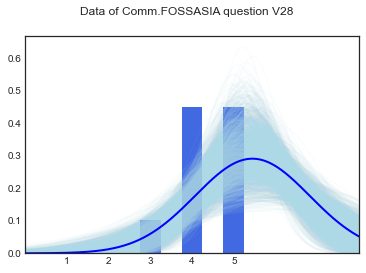

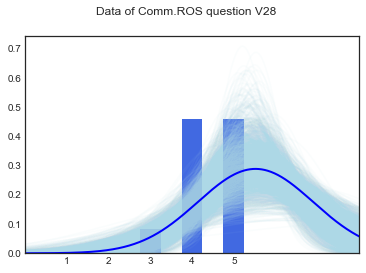

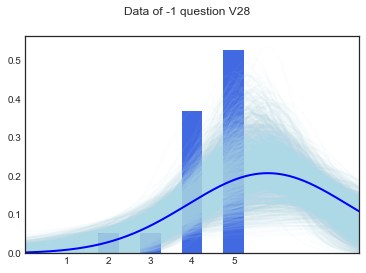

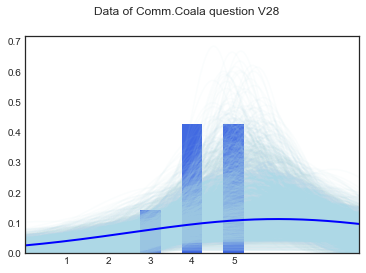

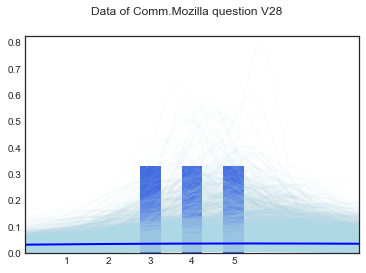

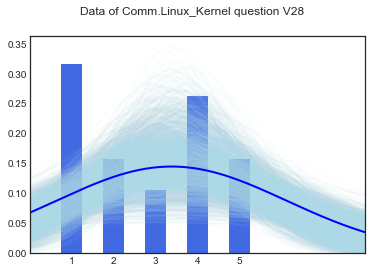

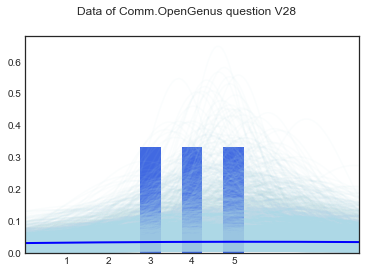

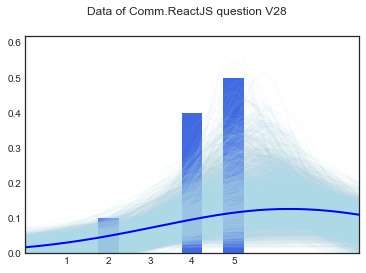

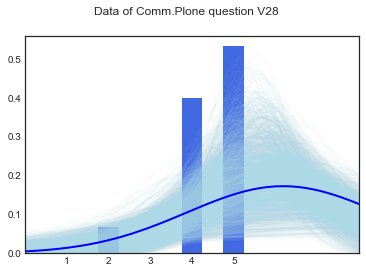

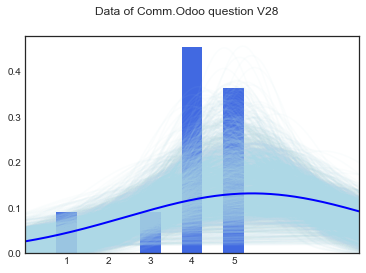

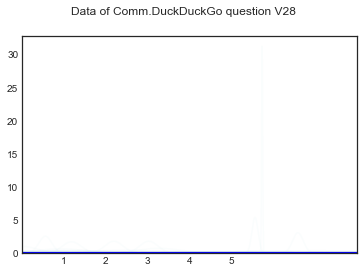

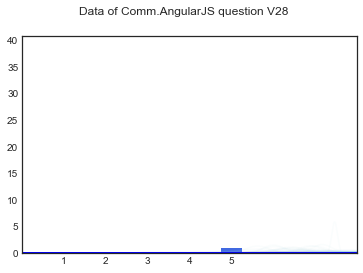

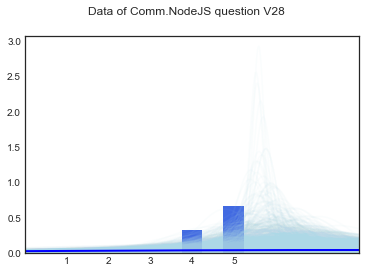

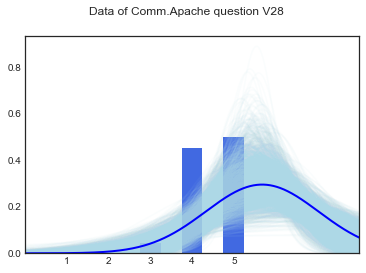

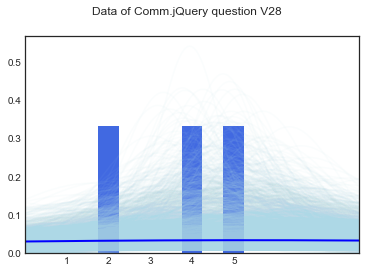

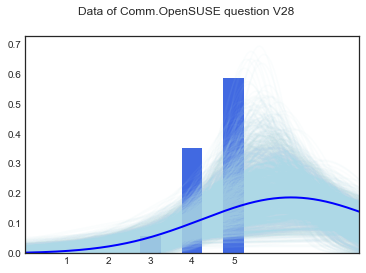

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [24]:
[plot_ppc_normal_density(df2,t_v28,c,'V28') for c in df2.Community.unique()]

### Density plot of mean distributions V28

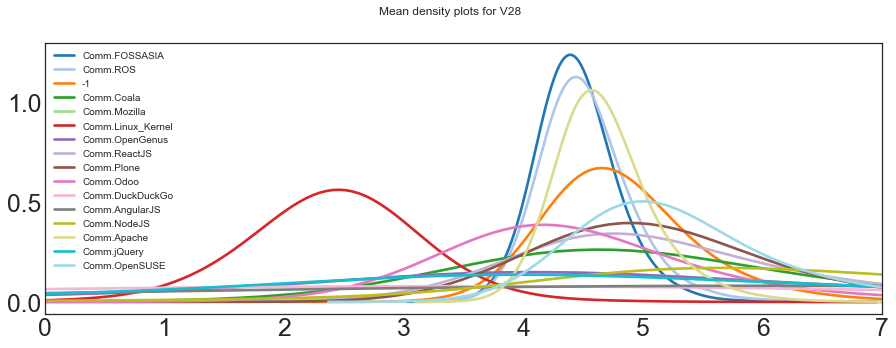

In [25]:
mean_densities(t_v28,'V28')

### Posterior Diagnosis

Below we look at some metrics to determine the quality of our analysis. The ESS and $\hat{R}$ (`r_hat`) values indicate good accuracy.

In [26]:
pm.summary(t_v28)

/home/pardo/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
theta_missing[0]   2.032   0.164   1.728    2.333      0.002    0.001   
theta_missing[1]   2.725   0.183   2.393    3.073      0.003    0.002   
mu[0]              4.810   0.631   3.725    6.006      0.006    0.005   
mu[1]              5.109   4.857  -4.394   13.834      0.041    0.034   
mu[2]              4.677   0.409   3.964    5.464      0.005    0.004   
mu[3]              5.042   1.691   2.441    8.583      0.025    0.020   
mu[4]              3.082   4.935  -6.209   12.283      0.039    0.034   
mu[5]              4.444   0.331   3.828    5.064      0.004    0.003   
mu[6]              2.380   0.694   1.092    3.693      0.006    0.005   
mu[7]              4.448   3.327  -1.723   11.601      0.030    0.027   
mu[8]              6.836   2.938   2.028   13.409      0.037    0.029   
mu[9]              4.441   1.195   2.506    6.772      0.018    0.016   
mu[10]             4.419   3.339  -2.190   11.400      0.031    0.026   
mu[11]             5.363   1.000   4.021    7.179      0.020    0.015   
mu[12]             5.179   1.123   3.665    7.067      0.025    0.021   
mu[13]             4.518   0.378   3.835    5.216      0.004    0.003   
mu[14]             5.326   1.508   2.965    8.133      0.026    0.020   
mu[15]             4.315   3.434  -2.194   11.324      0.032    0.028   
sigma[0]           1.920   0.722   0.889    3.208      0.009    0.006   
sigma[1]          26.184  14.820   2.821   49.998      0.126    0.092   
sigma[2]           1.350   0.479   0.607    2.218      0.007    0.005   
sigma[3]           3.519   3.567   0.599    8.675      0.070    0.050   
sigma[4]          26.874  14.426   3.914   49.999      0.115    0.087   
sigma[5]           1.372   0.366   0.773    2.043      0.005    0.003   
sigma[6]           2.749   0.944   1.347    4.456      0.011    0.008   
sigma[7]          10.690  10.717   0.502   33.936      0.146    0.103   
sigma[8]           8.583   9.831   0.069   29.329      0.168    0.119   
sigma[9]           3.022   1.950   0.947    6.088      0.031    0.023   
sigma[10]         11.032  11.099   0.551   34.988      0.158    0.113   
sigma[11]          2.129   1.185   0.705    4.087      0.024    0.017   
sigma[12]          2.308   1.357   0.826    4.424      0.030    0.021   
sigma[13]          1.381   0.426   0.723    2.170      0.006    0.004   
sigma[14]          3.154   2.311   0.833    6.745      0.043    0.031   
sigma[15]         11.626  11.121   0.767   35.751      0.168    0.122   

                  ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
theta_missing[0]    6473.0   6469.0    6531.0    9894.0    1.0  
theta_missing[1]    4768.0   4725.0    4776.0    7935.0    1.0  
mu[0]              10103.0   9480.0   11706.0    9742.0    1.0  
mu[1]              14196.0  10452.0   14143.0   12152.0    1.0  
mu[2]               6875.0   6425.0    8581.0    6581.0    1.0  
mu[3]               4489.0   3667.0    6426.0    4518.0    1.0  
mu[4]              15681.0  10642.0   15699.0   12028.0    1.0  
mu[5]               8581.0   8126.0    9801.0    7335.0    1.0  
mu[6]              12650.0  11373.0   13276.0   10505.0    1.0  
mu[7]              11965.0   7824.0   12626.0    7865.0    1.0  
mu[8]               6351.0   5038.0    7408.0    5713.0    1.0  
mu[9]               4276.0   2934.0    7334.0    5036.0    1.0  
mu[10]             11851.0   8009.0   12218.0    9507.0    1.0  
mu[11]              2604.0   2304.0    4215.0    3197.0    1.0  
mu[12]              1998.0   1406.0    4884.0    3411.0    1.0  
mu[13]              8082.0   7521.0    9779.0    7672.0    1.0  
mu[14]              3450.0   2761.0    5560.0    3877.0    1.0  
mu[15]             11453.0   7473.0   12040.0    8641.0    1.0  
sigma[0]            7129.0   6403.0    8671.0    8759.0    1.0  
sigma[1]           13896.0  12839.0   13368.0   10990.0    1.0  
sigma[2]            5090.0   4970.0    5730.0    6689.0    1.0  
sigma[3]            2592.0   2592.

## Question V29

In [11]:
t_v29 = infer('V29')

thresh2:	[1.5 2.5 3.5 4.5]
thresh_obs2:	[1.5 -- -- 4.5]


/home/pardo/.local/lib/python3.8/site-packages/pymc3/model.py:1668: ImputationWarning: Data in theta contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [mu]
>Slice: [theta_missing]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2574 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Posterior Predictive Check V29

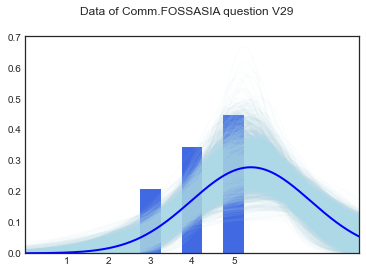

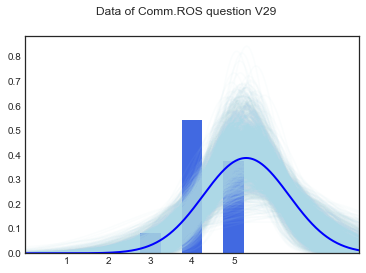

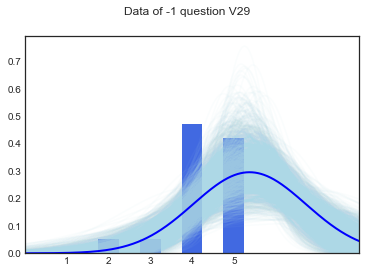

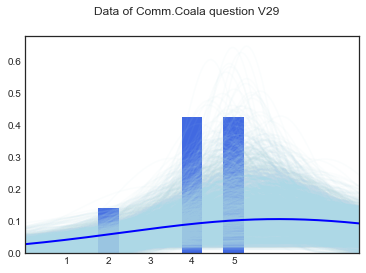

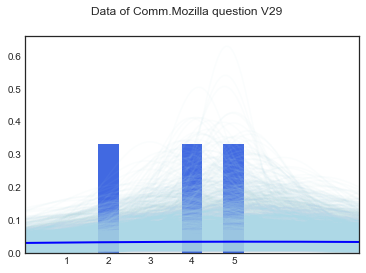

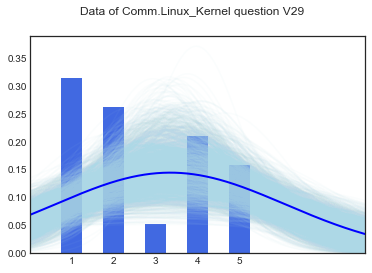

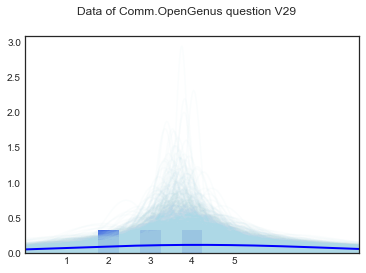

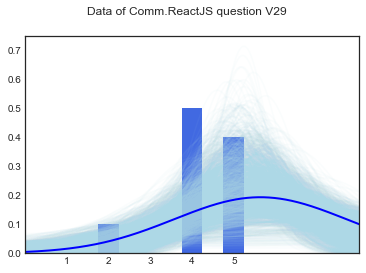

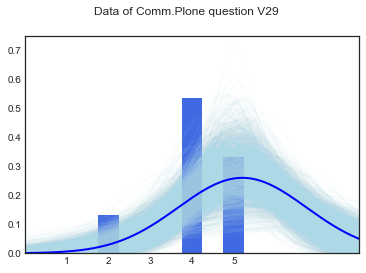

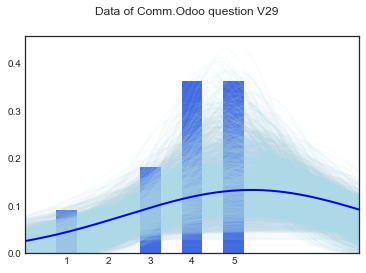

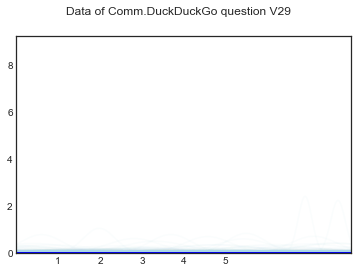

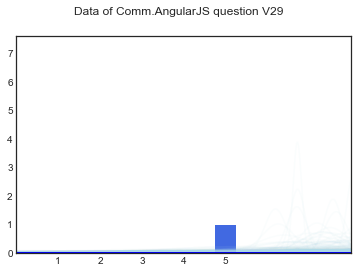

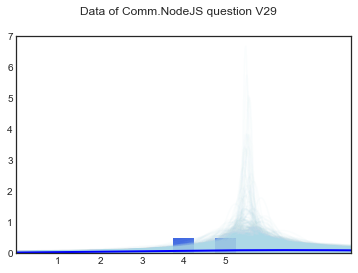

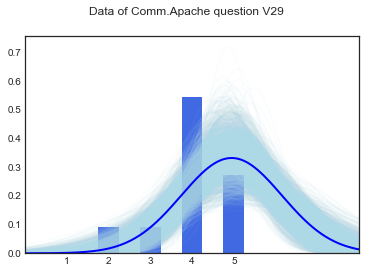

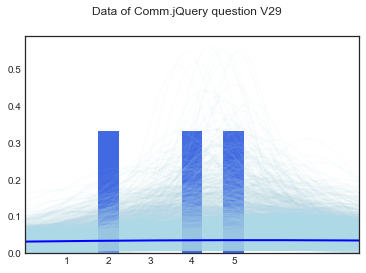

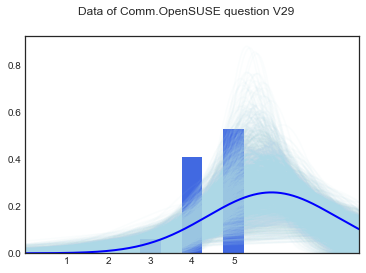

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [17]:
[plot_ppc_normal_density(df2,t_v29,c,'V29') for c in df2.Community.unique()]

### Density plot of mean distributions V29

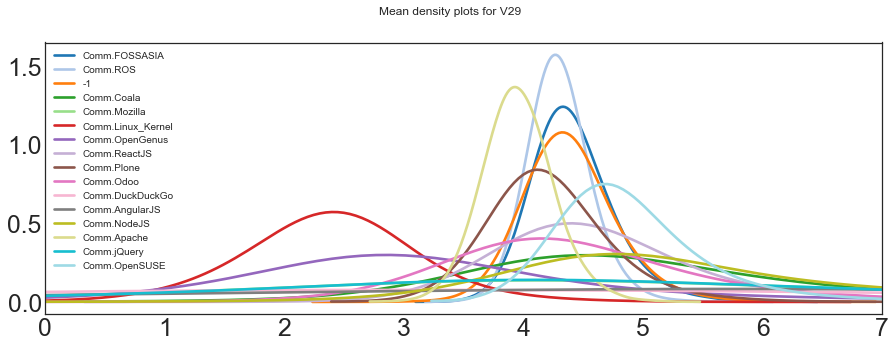

In [15]:
mean_densities(t_v29,'V29')

### Diagnosis

In [19]:
pm.summary(t_v29)

/home/pardo/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
theta_missing[0]   2.389   0.178   2.052    2.716      0.003    0.002   
theta_missing[1]   2.953   0.166   2.646    3.270      0.003    0.002   
mu[0]              4.376   0.385   3.673    5.104      0.003    0.002   
mu[1]              5.098   4.835  -4.086   14.101      0.041    0.032   
mu[2]              3.947   0.297   3.410    4.536      0.003    0.002   
mu[3]              5.061   1.745   2.272    8.712      0.025    0.020   
mu[4]              3.060   5.026  -6.311   12.648      0.041    0.037   
mu[5]              4.406   0.342   3.785    5.061      0.004    0.003   
mu[6]              2.349   0.714   1.031    3.773      0.006    0.005   
mu[7]              4.409   3.369  -2.103   11.283      0.031    0.028   
mu[8]              5.574   1.967   2.701    9.855      0.034    0.027   
mu[9]              4.422   1.163   2.450    6.628      0.016    0.013   
mu[10]             3.149   1.789  -0.106    6.843      0.027    0.022   
mu[11]             4.900   0.646   3.937    6.089      0.012    0.009   
mu[12]             4.204   0.489   3.345    5.160      0.005    0.004   
mu[13]             4.294   0.260   3.822    4.792      0.002    0.002   
mu[14]             4.633   0.930   3.134    6.390      0.014    0.011   
mu[15]             4.392   3.360  -2.138   11.147      0.031    0.027   
sigma[0]           1.346   0.426   0.694    2.129      0.005    0.003   
sigma[1]          25.808  14.694   2.868   50.000      0.126    0.093   
sigma[2]           1.203   0.291   0.728    1.754      0.003    0.003   
sigma[3]           3.720   3.600   0.691    9.112      0.066    0.050   
sigma[4]          26.861  14.449   3.887   49.998      0.118    0.090   
sigma[5]           1.431   0.379   0.816    2.128      0.005    0.004   
sigma[6]           2.752   0.974   1.321    4.478      0.012    0.009   
sigma[7]          11.282  10.928   0.646   34.985      0.153    0.109   
sigma[8]           3.893   5.285   0.050   11.622      0.096    0.068   
sigma[9]           2.985   1.785   0.902    5.838      0.029    0.021   
sigma[10]          3.329   4.731   0.178   10.062      0.086    0.061   
sigma[11]          1.538   0.765   0.558    2.870      0.015    0.011   
sigma[12]          1.535   0.546   0.749    2.500      0.007    0.005   
sigma[13]          1.028   0.284   0.579    1.564      0.004    0.003   
sigma[14]          2.063   1.229   0.648    4.085      0.021    0.015   
sigma[15]         11.125  10.830   0.652   34.662      0.151    0.109   

                  ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
theta_missing[0]    3488.0   3445.0    3536.0    5517.0    1.0  
theta_missing[1]    3130.0   3103.0    3132.0    4699.0    1.0  
mu[0]              14007.0  13414.0   14881.0   11606.0    1.0  
mu[1]              13969.0  11376.0   13860.0   13052.0    1.0  
mu[2]              11426.0  11039.0   11727.0    9830.0    1.0  
mu[3]               4796.0   3853.0    6897.0    4667.0    1.0  
mu[4]              15090.0   9113.0   15115.0   11479.0    1.0  
mu[5]               8502.0   8164.0    9531.0    8162.0    1.0  
mu[6]              12375.0  10692.0   12662.0    9342.0    1.0  
mu[7]              11736.0   7130.0   12516.0    8714.0    1.0  
mu[8]               3267.0   2732.0    5100.0    3773.0    1.0  
mu[9]               4977.0   3740.0    7674.0    4407.0    1.0  
mu[10]              4493.0   3228.0    6896.0    3577.0    1.0  
mu[11]              3118.0   2685.0    5141.0    3805.0    1.0  
mu[12]              8146.0   7282.0   10218.0    6538.0    1.0  
mu[13]             10936.0  10461.0   11986.0    8476.0    1.0  
mu[14]              4538.0   3638.0    7338.0    4662.0    1.0  
mu[15]             12012.0   7935.0   12682.0    9608.0    1.0  
sigma[0]            8899.0   8864.0    9410.0   11064.0    1.0  
sigma[1]           13642.0  12497.0   12899.0    9988.0    1.0  
sigma[2]            7040.0   6706.0    7545.0    8565.0    1.0  
sigma[3]            2996.0   2590.

## Question V30

In [20]:
t_v30=infer('V30')

thresh2:	[1.5 2.5 3.5 4.5]
thresh_obs2:	[1.5 -- -- 4.5]


/home/pardo/.local/lib/python3.8/site-packages/pymc3/model.py:1668: ImputationWarning: Data in theta contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [mu]
>Slice: [theta_missing]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2544 seconds.
The number of effective samples is smaller than 10% for some parameters.


### Posterior Predictive Check V30

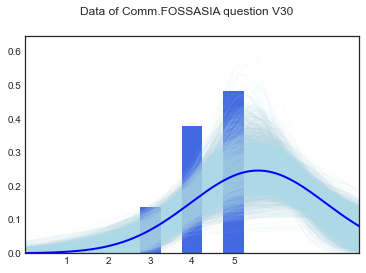

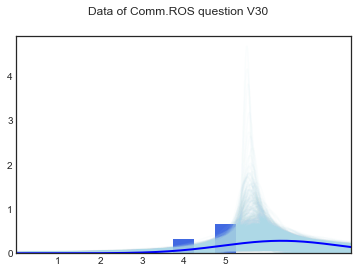

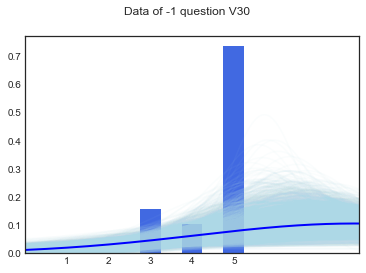

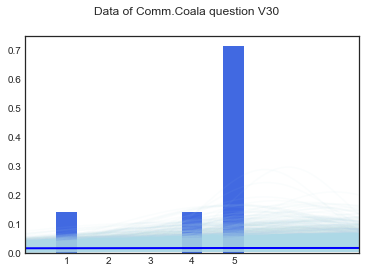

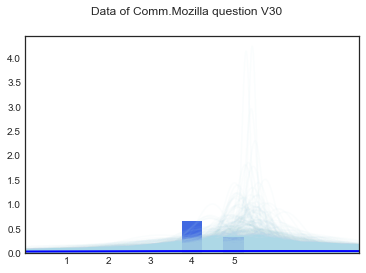

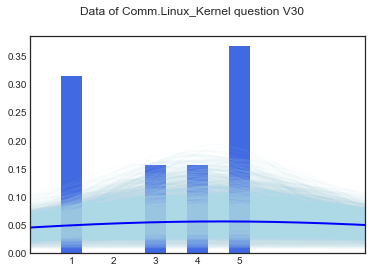

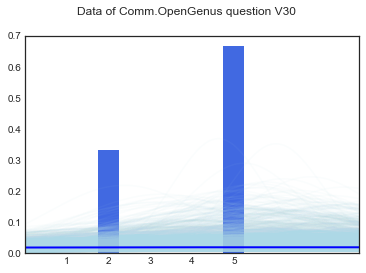

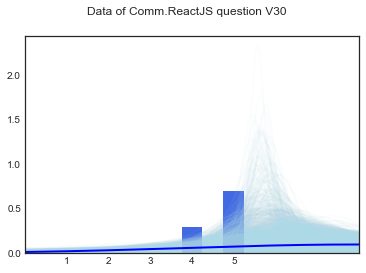

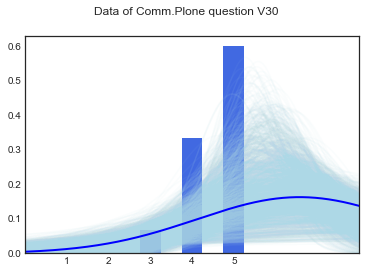

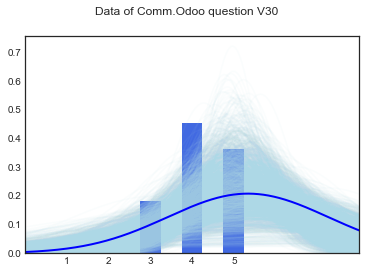

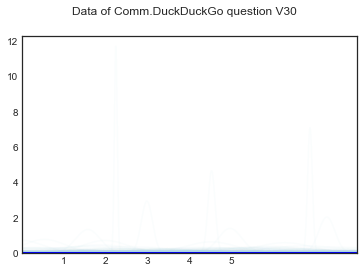

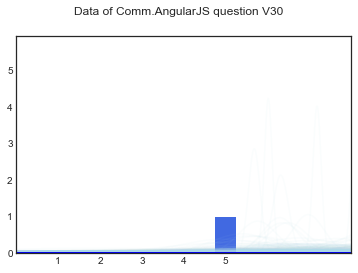

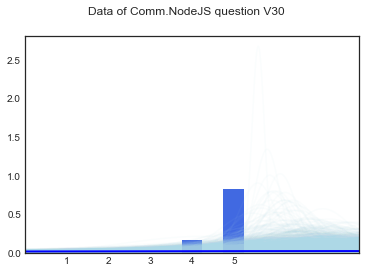

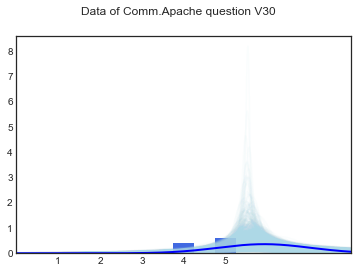

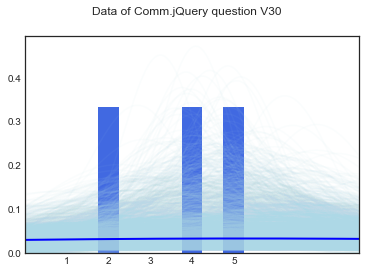

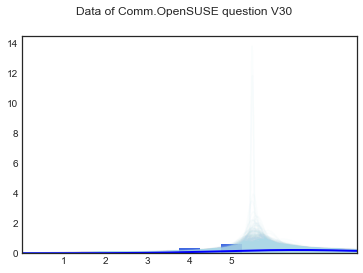

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [21]:
[plot_ppc_normal_density(df2,t_v30,c,'V30') for c in df2.Community.unique()]

### Density plot of mean distributions V30

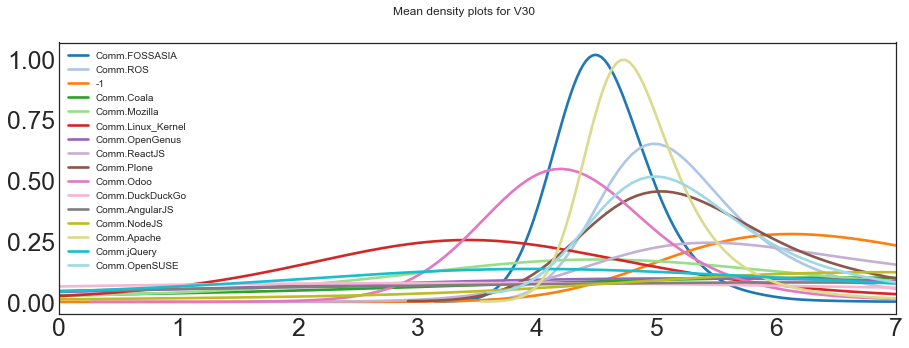

In [23]:
mean_densities(t_v30,'V30')

### Diagnosis V30

In [24]:
pm.summary(t_v30)

/home/pardo/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
theta_missing[0]   1.787   0.153   1.539    2.067      0.002    0.001   
theta_missing[1]   2.770   0.219   2.357    3.176      0.003    0.002   
mu[0]              6.881   1.635   4.397    9.978      0.022    0.016   
mu[1]              5.150   4.857  -4.285   13.862      0.043    0.033   
mu[2]              4.922   0.512   4.272    5.868      0.010    0.007   
mu[3]              6.357   4.133  -1.643   14.266      0.035    0.027   
mu[4]              3.135   4.951  -6.419   12.108      0.041    0.034   
mu[5]              4.578   0.411   3.840    5.337      0.005    0.004   
mu[6]              3.572   1.759   0.343    7.129      0.018    0.015   
mu[7]              4.855   2.993  -1.303   10.873      0.031    0.027   
mu[8]              7.715   3.604   1.097   15.321      0.035    0.027   
mu[9]              4.337   0.803   3.055    5.823      0.014    0.012   
mu[10]             5.126   4.311  -2.805   13.683      0.036    0.030   
mu[11]             5.580   1.262   4.178    7.909      0.039    0.029   
mu[12]             5.571   1.192   3.912    7.876      0.022    0.016   
mu[13]             5.335   0.821   4.392    6.795      0.025    0.019   
mu[14]             6.900   2.345   3.939   11.620      0.048    0.036   
mu[15]             4.279   3.399  -2.186   11.142      0.031    0.026   
sigma[0]           3.764   1.907   1.253    7.101      0.027    0.019   
sigma[1]          26.037  14.758   2.825   49.998      0.130    0.095   
sigma[2]           1.104   0.646   0.163    2.270      0.012    0.009   
sigma[3]          21.713  13.398   2.643   46.067      0.146    0.108   
sigma[4]          26.864  14.367   4.032   50.000      0.119    0.090   
sigma[5]           1.618   0.458   0.867    2.451      0.006    0.005   
sigma[6]           7.037   4.433   2.180   14.204      0.069    0.051   
sigma[7]           8.581  10.057   0.037   29.519      0.147    0.104   
sigma[8]          13.794  13.089   0.242   41.721      0.181    0.128   
sigma[9]           1.920   1.020   0.698    3.649      0.020    0.016   
sigma[10]         20.497  13.688   1.698   45.829      0.146    0.109   
sigma[11]          1.818   1.474   0.108    4.255      0.042    0.030   
sigma[12]          2.451   1.491   0.660    5.038      0.028    0.020   
sigma[13]          1.411   0.939   0.151    2.990      0.026    0.019   
sigma[14]          4.036   4.155   0.137   10.599      0.081    0.057   
sigma[15]         11.802  11.102   0.831   36.024      0.151    0.108   

                  ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
theta_missing[0]    8520.0   8355.0    9432.0   10864.0    1.0  
theta_missing[1]    5043.0   5025.0    5036.0    8070.0    1.0  
mu[0]               5522.0   5522.0    5938.0    8655.0    1.0  
mu[1]              12603.0  11081.0   12598.0   11970.0    1.0  
mu[2]               2538.0   2379.0    3914.0    3352.0    1.0  
mu[3]              13766.0  11550.0   13696.0   11963.0    1.0  
mu[4]              14651.0  10384.0   14668.0   12993.0    1.0  
mu[5]               7109.0   6569.0    8739.0    5994.0    1.0  
mu[6]               9685.0   6664.0   11261.0    7428.0    1.0  
mu[7]               9304.0   6049.0   10539.0    6984.0    1.0  
mu[8]              10414.0   8982.0   10505.0    9308.0    1.0  
mu[9]               3522.0   2381.0    8388.0    3943.0    1.0  
mu[10]             14010.0  10427.0   14003.0   11083.0    1.0  
mu[11]              1053.0    972.0    1716.0    1324.0    1.0  
mu[12]              3008.0   2721.0    4273.0    3839.0    1.0  
mu[13]              1088.0    977.0    1937.0    1499.0    1.0  
mu[14]              2434.0   2148.0    3201.0    3601.0    1.0  
mu[15]             12275.0   8280.0   12883.0    9218.0    1.0  
sigma[0]            4827.0   4827.0    5100.0    7262.0    1.0  
sigma[1]           12889.0  12151.0   12383.0   10467.0    1.0  
sigma[2]            2721.0   2463.0    3419.0    3623.0    1.0  
sigma[3]            8418.0   7634.

## Question V31

In [26]:
t_v31=infer('V31')

thresh2:	[1.5 2.5 3.5 4.5]
thresh_obs2:	[1.5 -- -- 4.5]


/home/pardo/.local/lib/python3.8/site-packages/pymc3/model.py:1668: ImputationWarning: Data in theta contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [mu]
>Slice: [theta_missing]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2440 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Posterior Predictive Check V31

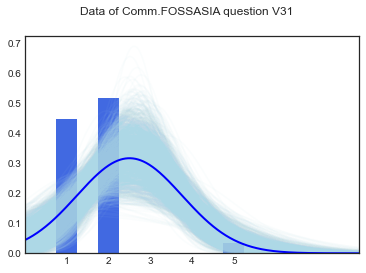

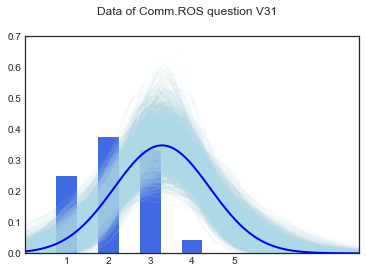

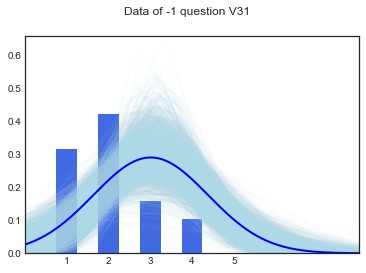

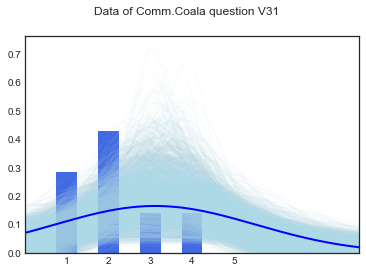

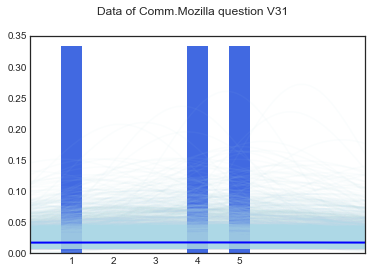

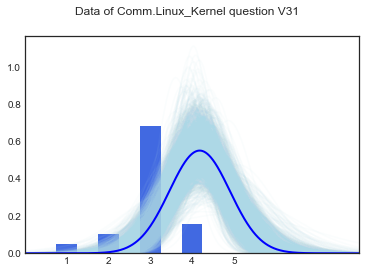

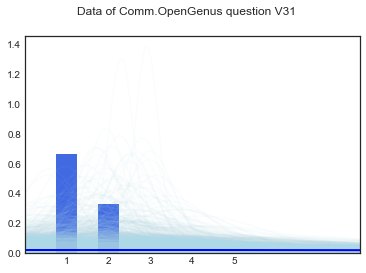

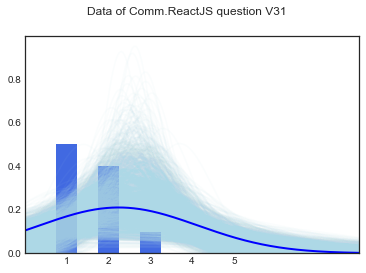

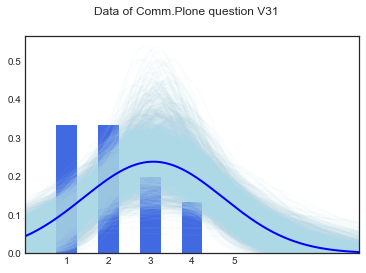

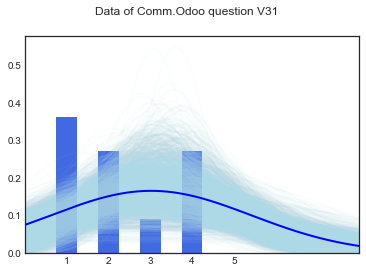

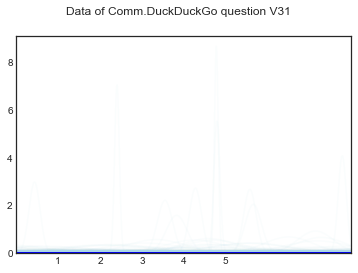

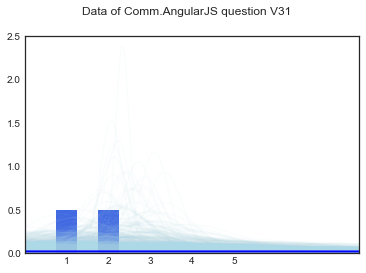

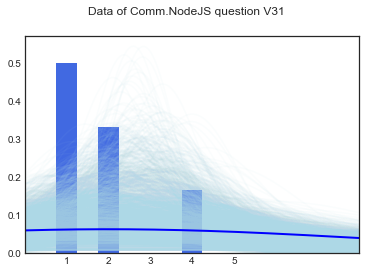

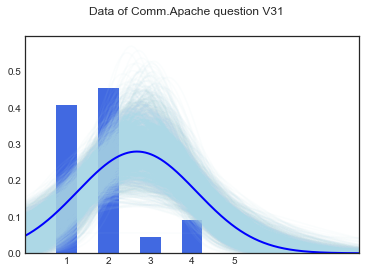

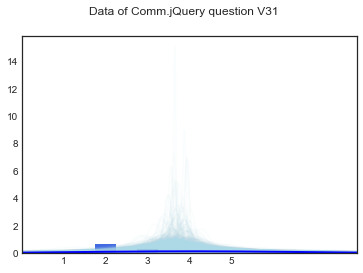

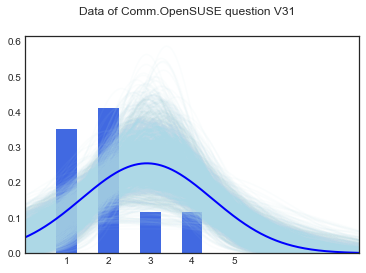

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [27]:
[plot_ppc_normal_density(df2,t_v31,c,'V31') for c in df2.Community.unique()]

### Density plot of mean distributions V31

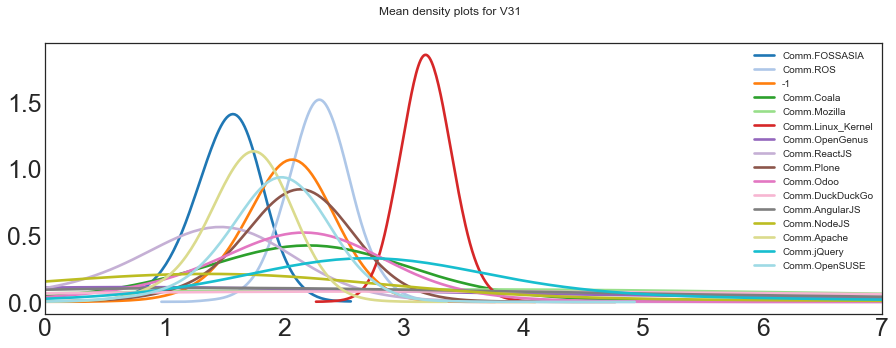

In [28]:
mean_densities(t_v31,'V31')

### Diagnosis V31

In [29]:
pm.summary(t_v31)

/home/pardo/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
theta_missing[0]   2.832   0.137   2.571    3.087      0.002    0.002   
theta_missing[1]   3.666   0.157   3.364    3.952      0.003    0.002   
mu[0]              2.015   0.365   1.311    2.676      0.003    0.002   
mu[1]              1.692   4.215  -6.349    9.846      0.035    0.033   
mu[2]              1.685   0.359   0.991    2.349      0.003    0.002   
mu[3]              2.120   1.025   0.220    3.963      0.011    0.011   
mu[4]              3.078   4.959  -6.275   12.321      0.042    0.035   
mu[5]              1.507   0.286   0.973    2.043      0.003    0.002   
mu[6]              3.183   0.215   2.766    3.576      0.003    0.002   
mu[7]              3.276   4.404  -5.420   11.377      0.036    0.032   
mu[8]              0.995   2.357  -3.928    5.552      0.026    0.028   
mu[9]              2.024   0.834   0.353    3.542      0.008    0.006   
mu[10]             0.987   4.077  -6.651    9.111      0.036    0.031   
mu[11]             1.921   0.434   1.098    2.736      0.004    0.003   
mu[12]             2.077   0.483   1.142    2.974      0.004    0.003   
mu[13]             2.284   0.266   1.774    2.785      0.003    0.002   
mu[14]             1.248   0.794  -0.316    2.616      0.009    0.007   
mu[15]             3.047   1.777   0.197    6.626      0.040    0.033   
sigma[0]           1.373   0.374   0.789    2.058      0.004    0.003   
sigma[1]          18.151  13.948   0.188   44.480      0.153    0.112   
sigma[2]           1.423   0.388   0.796    2.140      0.004    0.003   
sigma[3]           2.399   2.266   0.620    4.979      0.053    0.043   
sigma[4]          26.875  14.277   4.217   49.997      0.116    0.088   
sigma[5]           1.258   0.319   0.753    1.854      0.004    0.003   
sigma[6]           0.723   0.159   0.446    1.009      0.002    0.001   
sigma[7]          22.788  13.721   3.004   47.611      0.145    0.109   
sigma[8]           6.296   6.979   0.645   18.280      0.124    0.088   
sigma[9]           2.401   1.119   0.961    4.313      0.014    0.010   
sigma[10]         17.970  14.097   0.305   44.613      0.158    0.114   
sigma[11]          1.563   0.494   0.824    2.438      0.006    0.005   
sigma[12]          1.671   0.545   0.826    2.643      0.006    0.004   
sigma[13]          1.144   0.260   0.721    1.642      0.003    0.002   
sigma[14]          1.895   1.300   0.520    4.022      0.019    0.014   
sigma[15]          2.758   4.568   0.031    8.786      0.096    0.068   

                  ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
theta_missing[0]    4060.0   4060.0    4056.0    7255.0    1.0  
theta_missing[1]    3746.0   3746.0    3789.0    6366.0    1.0  
mu[0]              16654.0  16654.0   16976.0   12826.0    1.0  
mu[1]              14439.0   8109.0   14606.0   11237.0    1.0  
mu[2]              12056.0  12044.0   12223.0   11822.0    1.0  
mu[3]               8436.0   4657.0   11118.0    6511.0    1.0  
mu[4]              13637.0   9808.0   13634.0   11836.0    1.0  
mu[5]              11599.0  11599.0   11859.0   11815.0    1.0  
mu[6]               5762.0   5712.0    5772.0    8090.0    1.0  
mu[7]              14609.0   9679.0   14671.0   11795.0    1.0  
mu[8]               8227.0   3552.0   10324.0    5345.0    1.0  
mu[9]              11251.0   9799.0   11602.0    9782.0    1.0  
mu[10]             12476.0   8388.0   12961.0   10488.0    1.0  
mu[11]             12219.0  11593.0   12702.0   11103.0    1.0  
mu[12]             12566.0  12007.0   12789.0   10445.0    1.0  
mu[13]             11017.0  10477.0   11034.0    9777.0    1.0  
mu[14]              8146.0   6166.0    9270.0    8390.0    1.0  
mu[15]              1933.0   1409.0    3963.0    2259.0    1.0  
sigma[0]            9582.0   9019.0   10935.0   11897.0    1.0  
sigma[1]            8322.0   7702.0    8653.0    8879.0    1.0  
sigma[2]            7598.0   7598.0    8012.0    9834.0    1.0  
sigma[3]            1802.0   1395.

## Question V32

In [10]:
t_v32=infer('V32')

thresh2:	[1.5 2.5 3.5 4.5]
thresh_obs2:	[1.5 -- -- 4.5]


/home/pardo/.local/lib/python3.8/site-packages/pymc3/model.py:1668: ImputationWarning: Data in theta contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [mu]
>Slice: [theta_missing]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2343 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Posterior Predictive Check V32

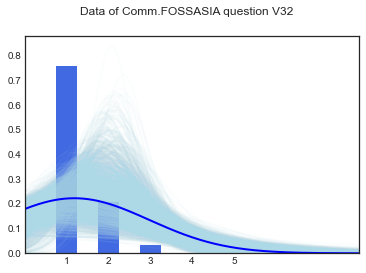

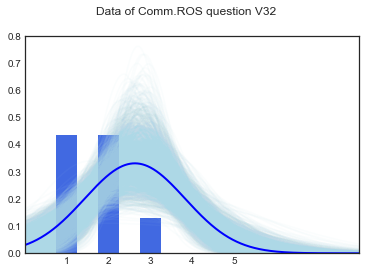

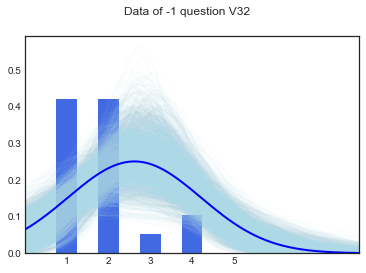

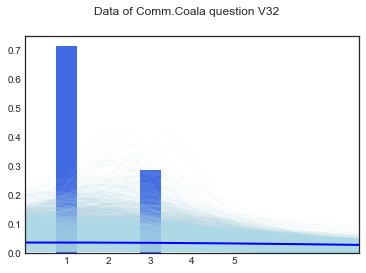

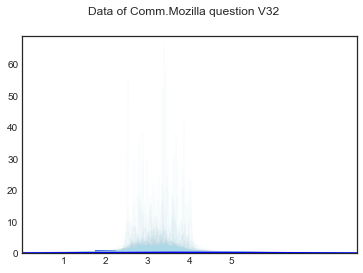

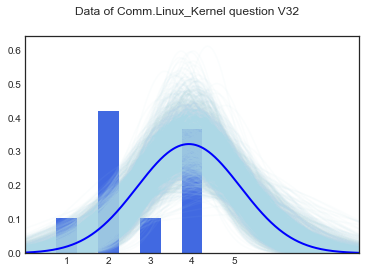

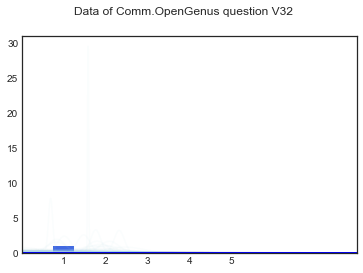

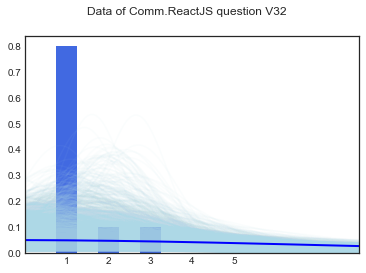

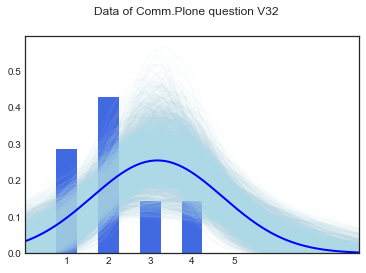

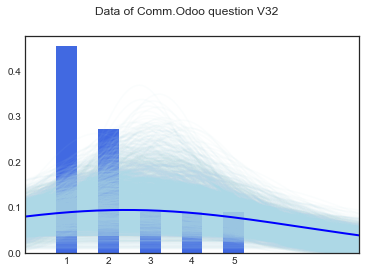

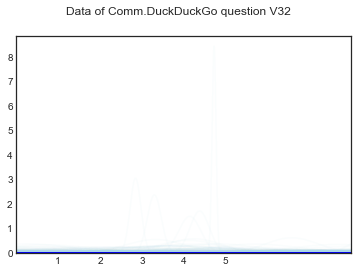

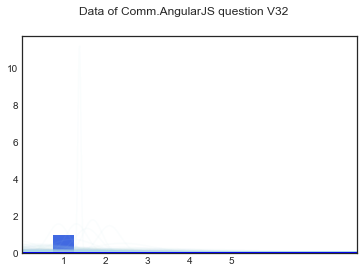

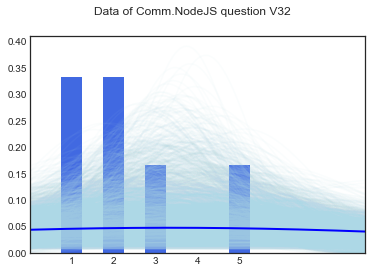

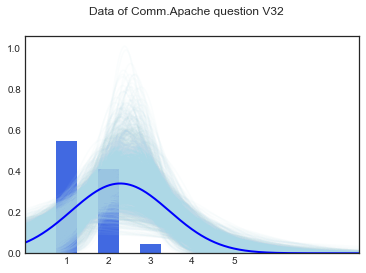

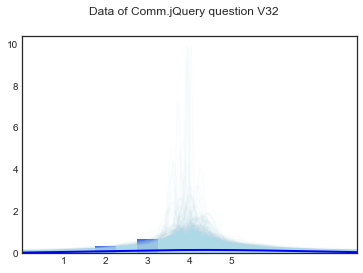

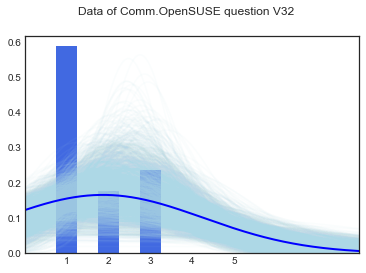

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [11]:
[plot_ppc_normal_density(df2,t_v32,c,'V32') for c in df2.Community.unique()]

### Density plot of mean distributions V32

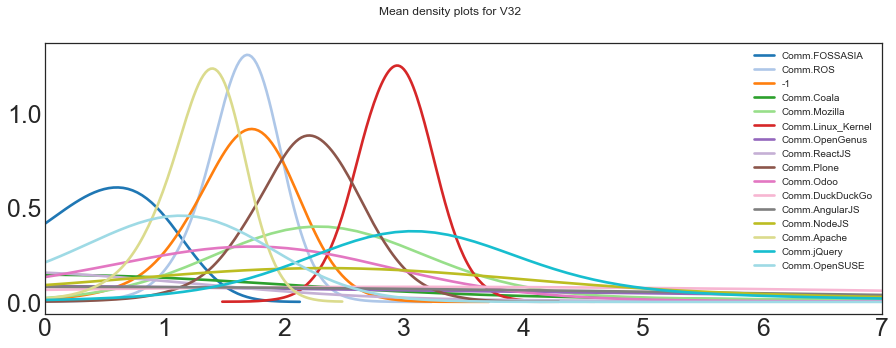

In [12]:
mean_densities(t_v32,'V32')

### Diagnosis V32

In [13]:
pm.summary(t_v32)

/home/pardo/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
theta_missing[0]   2.911   0.169   2.594    3.231      0.003    0.002   
theta_missing[1]   3.708   0.180   3.376    4.044      0.003    0.002   
mu[0]              1.624   0.450   0.709    2.387      0.004    0.003   
mu[1]              0.855   4.901  -8.462    9.939      0.042    0.036   
mu[2]              1.287   0.352   0.633    1.909      0.004    0.003   
mu[3]             -0.581   3.114  -7.138    5.288      0.031    0.026   
mu[4]              3.039   4.906  -5.918   12.729      0.040    0.035   
mu[5]              0.187   0.789  -1.253    1.366      0.015    0.010   
mu[6]              2.924   0.312   2.335    3.507      0.003    0.002   
mu[7]              2.640   1.666   0.223    5.521      0.053    0.040   
mu[8]              2.326   2.682  -3.079    7.740      0.026    0.024   
mu[9]              1.424   1.467  -1.558    3.907      0.017    0.018   
mu[10]             0.075   4.776  -9.003    8.941      0.044    0.033   
mu[11]             0.872   0.872  -0.857    2.238      0.011    0.011   
mu[12]             2.174   0.471   1.275    3.061      0.004    0.003   
mu[13]             1.636   0.306   1.046    2.194      0.003    0.002   
mu[14]            -1.595   2.667  -7.447    2.423      0.034    0.024   
mu[15]             3.359   1.536   0.827    6.567      0.029    0.023   
sigma[0]           1.591   0.488   0.838    2.473      0.005    0.004   
sigma[1]          25.904  14.741   2.749   49.996      0.128    0.093   
sigma[2]           1.172   0.429   0.523    1.970      0.006    0.004   
sigma[3]          10.721  10.485   0.939   33.746      0.171    0.125   
sigma[4]          26.948  14.326   4.048   49.998      0.120    0.090   
sigma[5]           1.792   0.801   0.627    3.236      0.015    0.011   
sigma[6]           1.236   0.272   0.762    1.726      0.003    0.002   
sigma[7]           1.748   4.174   0.005    6.101      0.111    0.079   
sigma[8]           8.261   7.960   0.924   23.108      0.125    0.091   
sigma[9]           4.195   2.883   1.166    8.859      0.046    0.033   
sigma[10]         24.091  15.412   0.021   47.389      0.147    0.105   
sigma[11]          2.405   1.242   0.894    4.286      0.022    0.018   
sigma[12]          1.564   0.517   0.769    2.502      0.006    0.004   
sigma[13]          1.202   0.358   0.629    1.856      0.005    0.003   
sigma[14]          7.795   8.801   0.731   25.016      0.231    0.176   
sigma[15]          2.487   4.252   0.028    7.933      0.077    0.054   

                  ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
theta_missing[0]    4051.0   4051.0    4044.0    6563.0    1.0  
theta_missing[1]    4440.0   4440.0    4450.0    8312.0    1.0  
mu[0]              13501.0  13501.0   14395.0   11610.0    1.0  
mu[1]              13480.0   9060.0   13585.0   12020.0    1.0  
mu[2]               8184.0   8184.0    9285.0    8583.0    1.0  
mu[3]              10142.0   7065.0   10826.0    7026.0    1.0  
mu[4]              14970.0   9783.0   14911.0   11255.0    1.0  
mu[5]               2866.0   2866.0    3156.0    4290.0    1.0  
mu[6]              10465.0   9799.0   10748.0   10652.0    1.0  
mu[7]                984.0    888.0    2665.0    1076.0    1.0  
mu[8]              11020.0   6001.0   12214.0    7327.0    1.0  
mu[9]               7889.0   3188.0   10056.0    7021.0    1.0  
mu[10]             11729.0  10230.0   11870.0   11361.0    1.0  
mu[11]              6055.0   3219.0    7143.0    8700.0    1.0  
mu[12]             12942.0  12469.0   13082.0   10467.0    1.0  
mu[13]             10830.0  10830.0   11320.0   10031.0    1.0  
mu[14]              6231.0   6231.0    6775.0    3757.0    1.0  
mu[15]              2766.0   2147.0    4943.0    2885.0    1.0  
sigma[0]            8979.0   8885.0    9797.0   10065.0    1.0  
sigma[1]           13240.0  12651.0   12923.0   11364.0    1.0  
sigma[2]            5136.0   4990.0    5713.0    6739.0    1.0  
sigma[3]            3745.0   3538.

## Question V33

In this section we explore the results of analyzing question _V33: "I don’t consider a pull
request/patch, unless I trust the contributor"_

### Model

In [27]:
t_v33=infer('V33')

thresh2:	[1.5 2.5 3.5 4.5]
thresh_obs2:	[1.5 -- -- 4.5]


/home/pardo/.local/lib/python3.8/site-packages/pymc3/model.py:1668: ImputationWarning: Data in theta contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [mu]
>Slice: [theta_missing]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2486 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
pm.model_to_graphviz(ordinal_model_multi_groups)

### Posterior Predictive Check V33

First we check whether our analysis correctly models the data. To this end, we plot a posterior predictive check. Concretely, we use a bar plot to show the row data, and we overlay the normal distribution obtained from the inference. The light blue lines are draws from the chain, the thicker blue line is the mean.

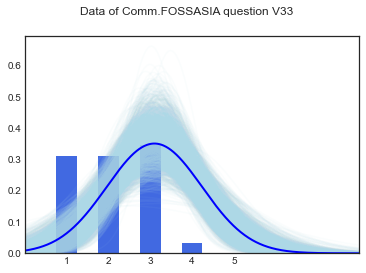

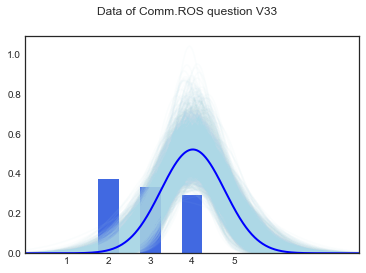

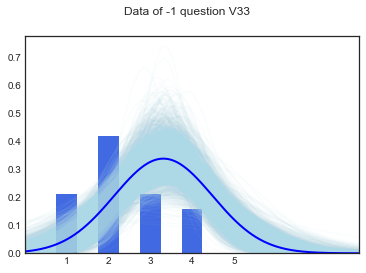

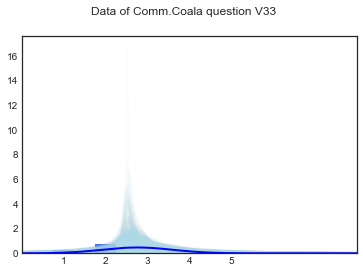

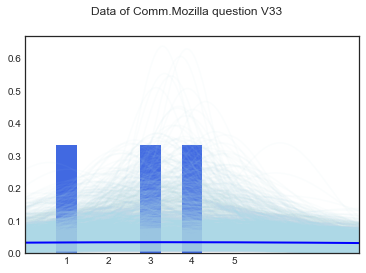

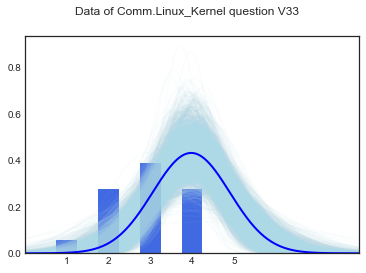

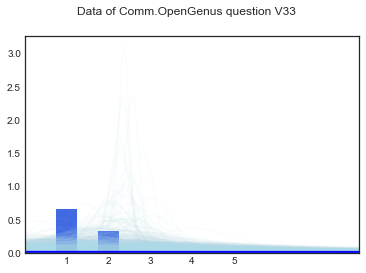

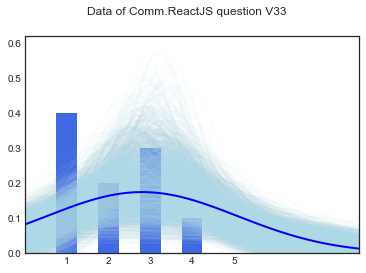

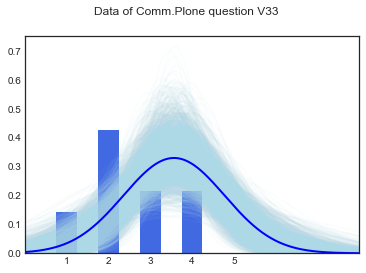

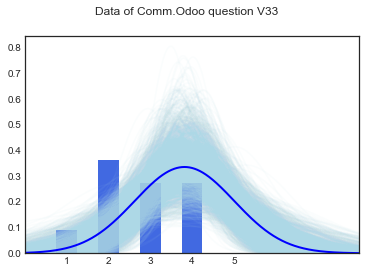

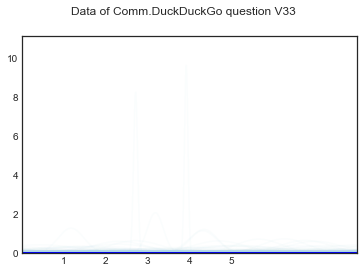

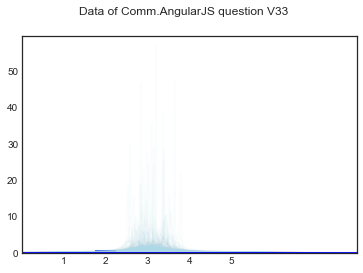

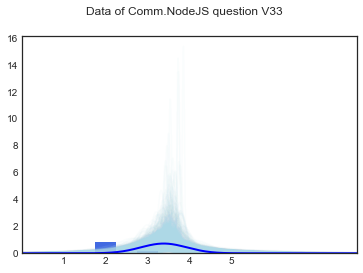

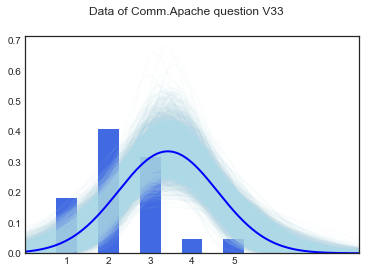

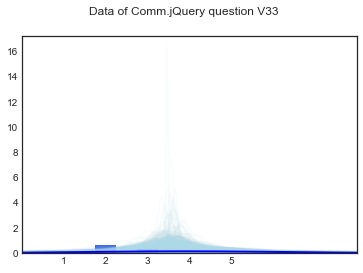

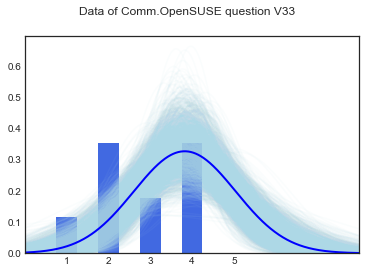

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [19]:
[plot_ppc_normal_density(df2,t_v33,c,'V33') for c in df2.Community.unique()]

### Density plot of mean distributions V33

Here we show the density plot of the posterior means for each community. This plot allows us to determine the governance style of a community. See Table 4 in accompanying paper.

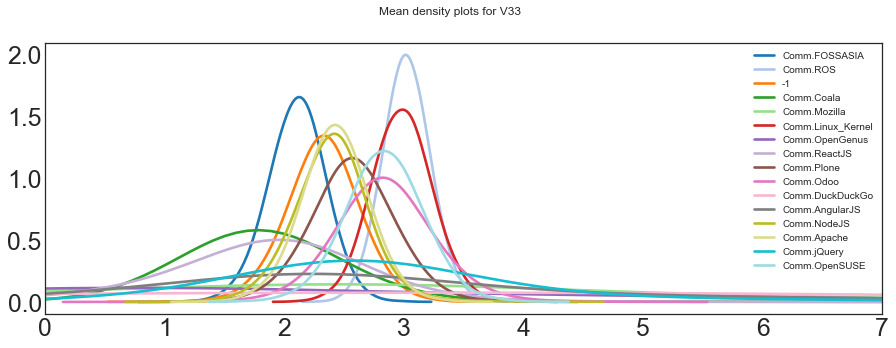

In [28]:
mean_densities(t_v33,'V33')

### Diagnosis V33

Below we look at some metrics to determine the quality of our analysis. The ESS and $\hat{R}$ (`r_hat`) values indicate good accuracy.

In [12]:
pm.summary(t_v33)

/home/pardo/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
theta_missing[0]   2.673   0.120   2.459    2.914      0.007    0.005   
theta_missing[1]   3.484   0.140   3.219    3.751      0.009    0.006   
mu[0]              2.308   0.294   1.737    2.842      0.008    0.006   
mu[1]              2.613   2.618  -1.710    8.734      0.084    0.095   
mu[2]              2.404   0.265   1.907    2.894      0.008    0.005   
mu[3]              1.739   0.401   1.046    2.465      0.013    0.010   
mu[4]              2.914   4.932  -5.853   12.096      0.125    0.107   
mu[5]              2.088   0.235   1.675    2.558      0.007    0.005   
mu[6]              2.983   0.261   2.488    3.469      0.010    0.007   
mu[7]              2.532   3.382  -4.471    9.063      0.109    0.112   
mu[8]              2.387   0.286   1.823    2.862      0.010    0.007   
mu[9]              2.820   0.394   2.068    3.564      0.013    0.009   
mu[10]             0.985   4.095  -6.287    9.783      0.113    0.111   
mu[11]             2.834   0.321   2.239    3.433      0.011    0.008   
mu[12]             2.576   0.371   1.842    3.270      0.012    0.009   
mu[13]             3.004   0.196   2.668    3.397      0.009    0.007   
mu[14]             1.772   0.828   0.057    3.121      0.025    0.018   
mu[15]             2.977   1.844   0.614    7.023      0.160    0.126   
sigma[0]           1.179   0.293   0.714    1.766      0.008    0.006   
sigma[1]           5.337   8.114   0.008   20.631      0.395    0.279   
sigma[2]           1.171   0.259   0.758    1.647      0.009    0.006   
sigma[3]           0.778   0.682   0.036    1.773      0.028    0.020   
sigma[4]          27.453  14.171   3.972   49.352      0.370    0.283   
sigma[5]           1.131   0.254   0.727    1.593      0.009    0.006   
sigma[6]           0.925   0.214   0.562    1.328      0.007    0.005   
sigma[7]          11.204  10.978   0.636   35.165      0.501    0.361   
sigma[8]           0.531   0.360   0.048    1.105      0.014    0.010   
sigma[9]           1.184   0.395   0.587    1.923      0.013    0.010   
sigma[10]         17.134  14.148   0.317   45.193      0.530    0.383   
sigma[11]          1.214   0.299   0.723    1.760      0.010    0.008   
sigma[12]          1.200   0.339   0.649    1.850      0.011    0.008   
sigma[13]          0.762   0.157   0.487    1.054      0.005    0.004   
sigma[14]          2.199   1.191   0.788    4.250      0.051    0.036   
sigma[15]          2.426   4.292   0.025    7.215      0.315    0.223   

                  ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
theta_missing[0]     283.0   283.0     284.0     575.0   1.01  
theta_missing[1]     263.0   263.0     264.0     493.0   1.01  
mu[0]               1449.0  1430.0    1427.0    1288.0   1.00  
mu[1]                979.0   381.0    1086.0     653.0   1.01  
mu[2]               1243.0  1197.0    1247.0    1118.0   1.00  
mu[3]               1006.0   796.0    1118.0     790.0   1.00  
mu[4]               1564.0  1060.0    1569.0    1154.0   1.00  
mu[5]               1236.0  1209.0    1221.0    1109.0   1.00  
mu[6]                638.0   636.0     651.0     741.0   1.00  
mu[7]                966.0   456.0    1119.0     686.0   1.00  
mu[8]                870.0   821.0     855.0     932.0   1.00  
mu[9]                931.0   882.0     945.0     781.0   1.00  
mu[10]              1313.0   680.0    1345.0    1032.0   1.00  
mu[11]               883.0   863.0     916.0     872.0   1.01  
mu[12]               970.0   941.0     986.0     892.0   1.00  
mu[13]               442.0   441.0     444.0     798.0   1.02  
mu[14]              1069.0  1069.0    1234.0     907.0   1.00  
mu[15]               133.0   107.0     358.0     138.0   1.01  
sigma[0]            1196.0  1180.0    1215.0    1211.0   1.00  
sigma[1]             423.0   423.0     343.0     827.0   1.01  
sigma[2]             910.0   812.0    1079.0     987.0   1.00  
sigma[3]             596.0   596.0     738.0     644.0  

array([<AxesSubplot:title={'center':'x'}>], dtype=object)

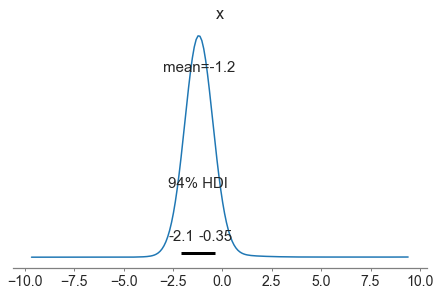

In [32]:
# pm.densityplot([t_v33['mu'][:,comm_to_code(df2,'Comm.Coala')],t_v33['mu'][:,comm_to_code(df2,'Comm.Linux_Kernel')]])
pm.plot_posterior(t_v33['mu'][:,comm_to_code(df2,'Comm.Coala')]-t_v33['mu'][:,comm_to_code(df2,'Comm.Linux_Kernel')])

/home/pardo/.local/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/pardo/.local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


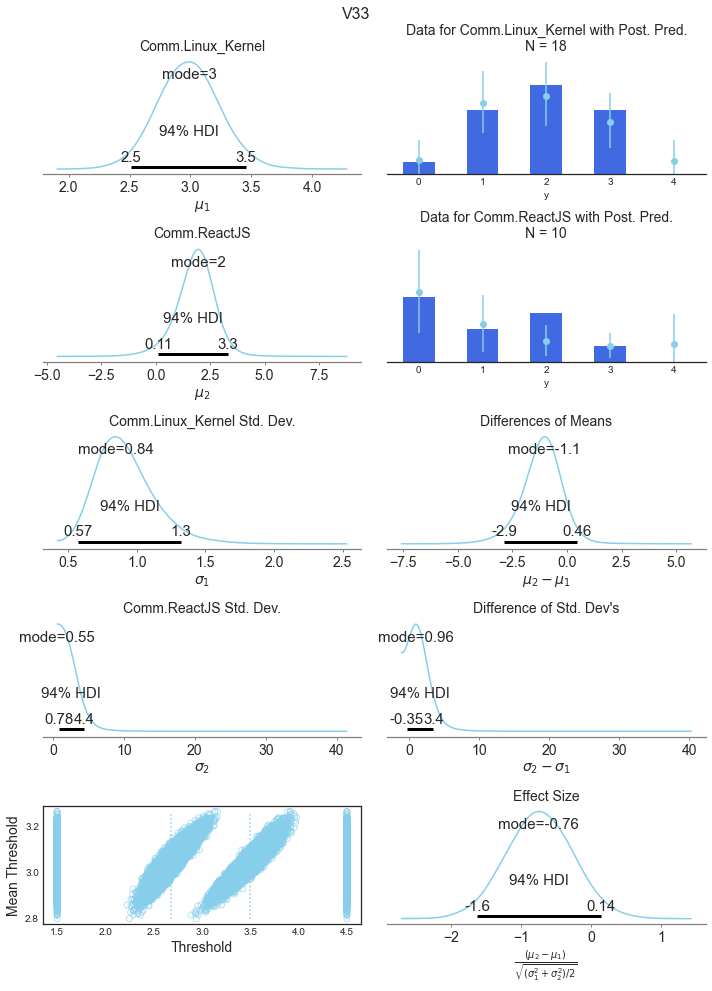

In [34]:
com(t_v33,df2,'Comm.Linux_Kernel','Comm.ReactJS','V33')

In [63]:
def ppc_count_cdfs(trace2,df2,com1,q):
    mu2 = trace2['mu']
    sigma2 = trace2['sigma']
    code_com1 = comm_to_code(df2,com1)
    
    # Concatenate the fixed thresholds into the estimated thresholds
    n = trace2['theta_missing'].shape[0]
    thresholds2 = np.c_[np.tile([1.5], (n,1)),
                        trace2['theta_missing'],
                        np.tile([4.5], (n,1))]

    fig, ax1 = plt.subplots(1, figsize=(10,4))

    # Posterior predictive probabilities of the outcomes
    threshCumProb2A = np.empty(thresholds2.shape)
    for i in np.arange(threshCumProb2A.shape[0]):
        threshCumProb2A[i] = norm().cdf((thresholds2[i] - mu2[i,code_com1])/sigma2[i,code_com1])    
    outProb2A = (np.c_[threshCumProb2A, np.tile(1, (thresholds2.shape[0],1))]
           - np.c_[np.tile(0, (thresholds2.shape[0],1)), threshCumProb2A])
    yerr2A = np.abs(np.subtract(pm.hpd(outProb2A), outProb2A.mean(axis=0).reshape(-1,1)))

    ax1.errorbar(x = np.arange(outProb2A.shape[1]), y=outProb2A.mean(axis=0),
                 yerr=yerr2A.T, color='darkblue', fmt='o', capthick=3)

    # Count bars from the data
    pd.Series((count_per_data_value(df2,com1,q)/count_per_data_value(df2,com1,q).sum())).plot.bar(ax=ax1, rot=0, color='royalblue')
    ax1.set_title('Data for {0} with Post. Pred.\nN = {1}'.format(com1, df2[(df2.Community == com1) & (df2[q]!='-1') ][q].size))#, fontdict=f_dict)
    ax1.set_xlabel('y')
#     sns.despine(ax=ax1, left=True)
    ax1.yaxis.set_visible(False)

    plt.show()

/home/pardo/.local/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/pardo/.local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


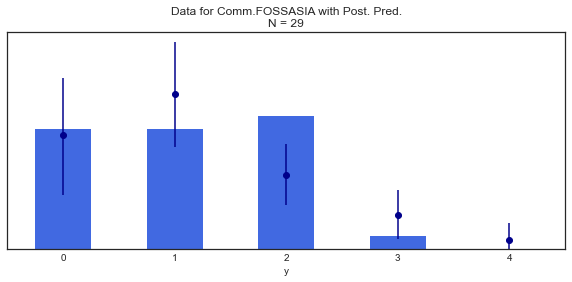

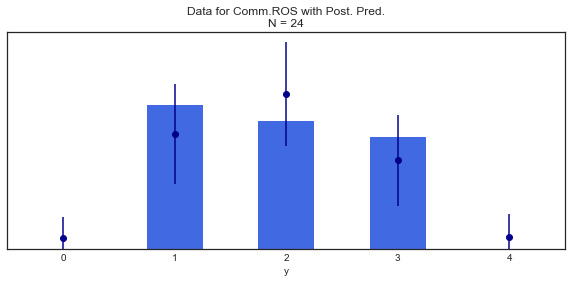

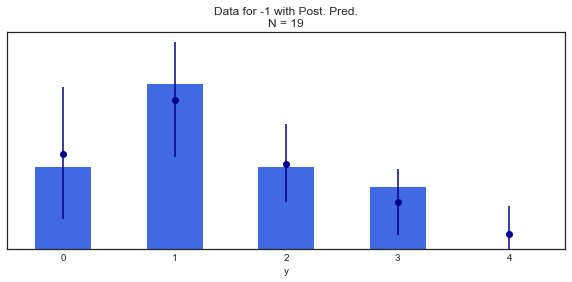

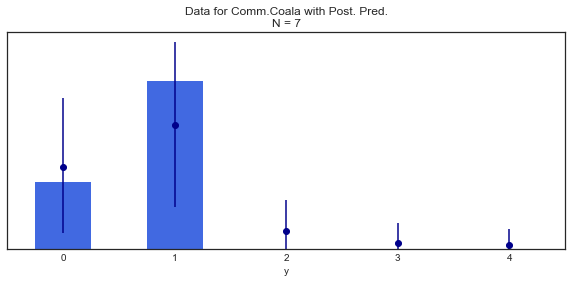

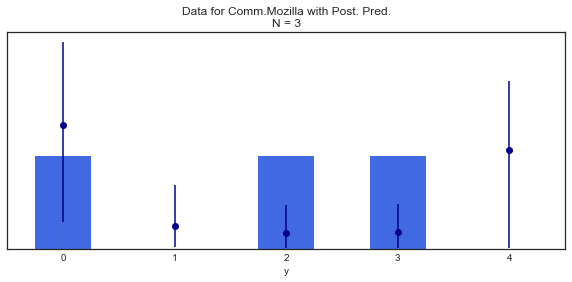

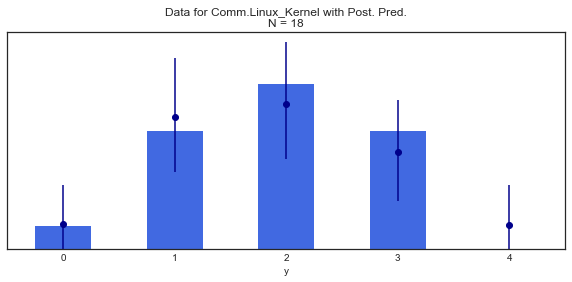

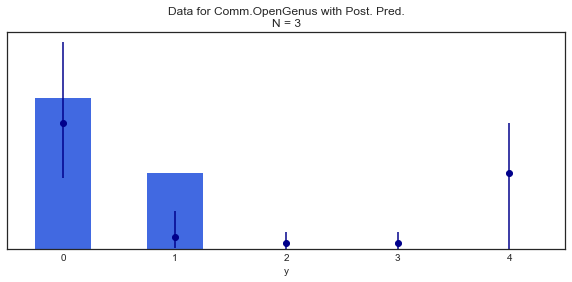

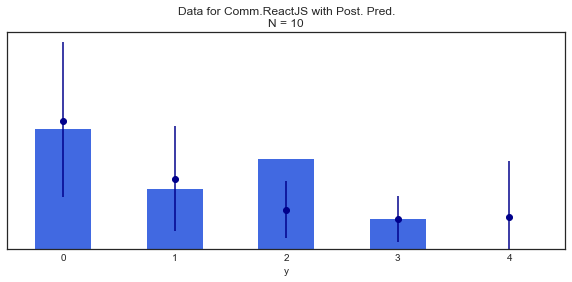

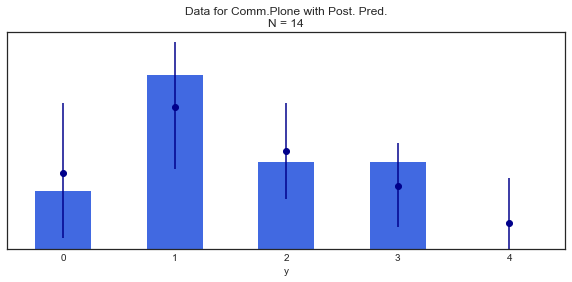

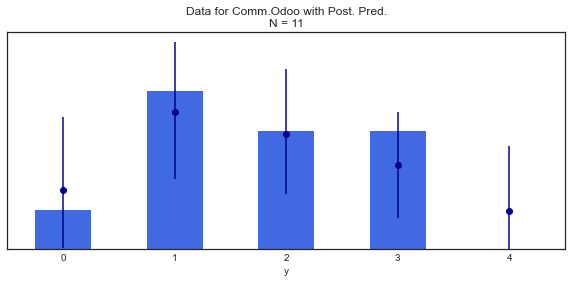

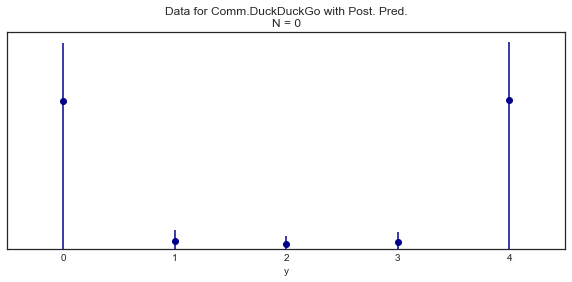

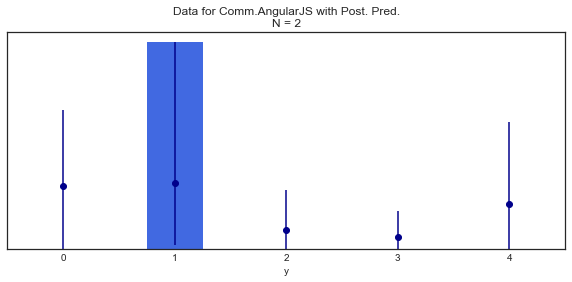

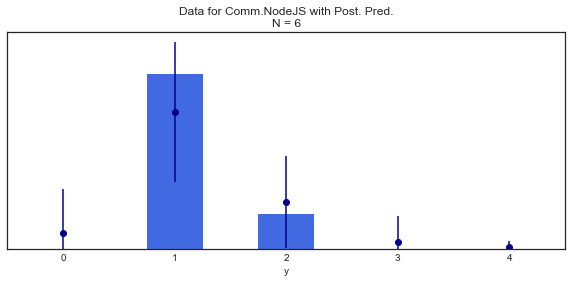

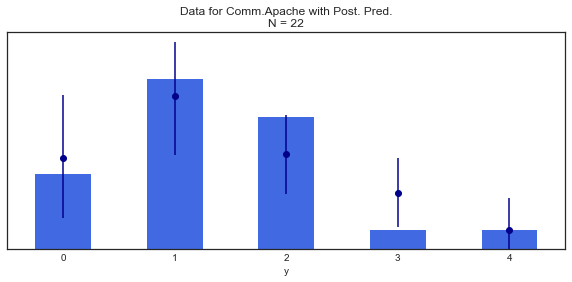

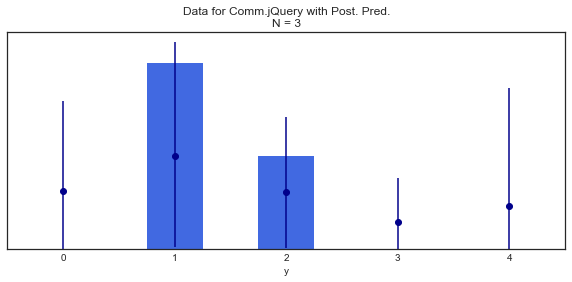

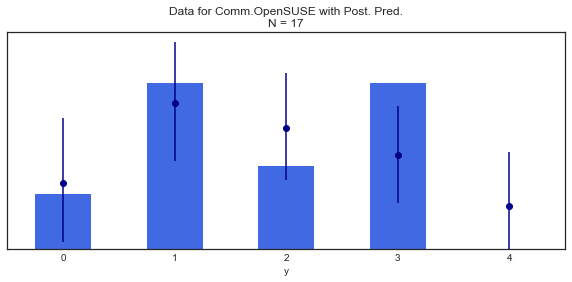

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [65]:
[ppc_count_cdfs(t_v33,df2,c,'V33') for c in df2.Community.unique()]

# Statistical Analysis of Data on Pull-Request Governance Models in FOSS Commununities
**by Raul Pardo. Adam Alami. Andrzej Wąsowski**

In this notebook we study how different Free & Open-Source Software (FOSS) communities handle Pull Requests (PRs). In particular, we compare how _protective_, _equitable_ and _lenient_ FOSS communities are in handling PRs. 

This is a mixed methods study (qualitative and quantitative). The findings of the first component were published in the publication listed below:
Alami, Adam, Marisa Leavitt Cohn, and Andrzej Wasowski. "How Do FOSS Communities Decide to Accept Pull Requests?" In Proceedings of the Evaluation and Assessment on Software Engineering (EASE'20).

This notebook is the stastical analysis of the quantitative data for a new paper under submission.






## The Goals of the Analysis

We have collected information related to PR handling from members of the following FOSS communities [NOTE: reference to the study]: FOSSASIA, Odoo, DuckDuckGo, Linux Kernel, Coala, ROS, Plone, ReactJS, AngularJS, NodeJS, OpenGenus, Mozilla, OpenSUSE, jQuery, Apache. 387 respondents have indicated their project as 'Other' (than the above listed).

We asked the respondents (open source software contributors) 12 questions, some with several subquestions, which clarify how they handle pull request evaluation in their communities, how they act when they are evaluators, and how do they feel when they are contributors, subjected  to evaluation.  The attached dataset contains only answers to 7 qantitative questions relevant for this analysis.  We repeat these questions here for your convenience:

**V27.** *In general I  say no to most pull requests (PR)/patches. The contributor has to be persistent and prove that the PR/patch worth evaluating.*

**V28.** *I don't consider a pull request/patch, unless I trust the contributor.*

**V29.** *I don't consider a pull request/patch, unless the contributor is reliable.*

**V30.** *I don't consider a pull request/patch, unless I have a strong relationship with the contributor.*

**V31.** *I assess every pull request/patch in the same manner irrespective of the contributor.*

**V32.** *I assess pull requests/patches purely on technical grounds.*

**V33.** *I never say no to a pull request/patch. If the quality of the PR/patch is not mergeable, then I mentor the contributor to elevate his/her PR/patch to a mergeable state.*

Each of the questions was given a closed answer on a 5-step Likert-scale: (1) I strongly agree, (2) I agree, (3) Neutral, (4) I disagree, (5) I strongly disagree.

We are interested in comparing how *protective*, *equitable* and *lenient* the different communities are. Below we precisely describe the criteria to classify a community within a category.

**Protective.** A community is classified as “Protective” when the response from this community is positive in at least one of these variables V28 (“I don't consider a pull request/patch, unless I trust the contributor”), V29 (“I don't consider a pull request/patch, unless the contributor is reliable.”), and V30 (“I don't consider a pull request/patch, unless I have a strong relationship with the contributor.”). It is possible that positive evaluations of V27 (“In general I  say no to most pull requests (PR)/patches”) can be included in this evaluation too.

**Equitable.** A community is classified as “Equitable” when the response from this community is positive in at least one of these variables V31 (“I assess every pull request/patch in the same manner irrespective of the contributor.”), V32 (“I assess pull requests/patches purely on technical grounds.”).  The equitability in community is expected to find positive answers on V31, V32 which have different tone compared to V33 (“I never say no to a pull request/patch. If the quality of the PR/patch is not mergeable, then I mentor the contributor to elevate his/her PR/patch to a mergeable state.”) in question.

**Lenient.** A community is classified as “Lenient” when the response from this community is positive V33 (“I never say no to a pull request/patch. If the quality of the PR/patch is not mergeable, then I mentor the contributor to elevate his/her PR/patch to a mergeable state.”).

The table below summarizes the variables we study for each category. For a category $c \in \{\mathit{protective, equitable, lenient}\}$ and the set of variables for that category (denoted as $V_c$), we say that a community is $c$ iff it is positive (see remark above) to either of the questions in $V_c$. For instance, we say that a community is *lenient* iff it is positive to either *V31* or *V32*.


| Category   | ID   | Variable                                                                                                           |
|------------|------|--------------------------------------------------------------------------------------------------------------------|
| Protective |      |                                                                                                                    |
|            | V27  | In general I  say no to most pull requests (PR)/patches”) can be included in this evaluation too.                  |
|            | V28  | I don't consider a pull request/patch, unless I trust the contributor.                                             |
|            | V29  | I don't consider a pull request/patch, unless the contributor is reliable.                                         |
|            | V30  | I don't consider a pull request/patch, unless I have a strong relationship with the contributor.                   |
| Equitable  |      |                                                                                                                    |
|            | V31  | I assess every pull request/patch in the same manner irrespective of the contributor.                              |
|            | V32  | I assess pull requests/patches purely on technical grounds.                                                        |
| Lenient    |      |                                                                                                                    |
|            | V33  | I never say no to a pull request/patch. I mentor the contributor to elevate his/her PR/patch to a mergeable state. |

## Hypothesis

We test the veracity of the following hypotheses using Bayesian Data Analysis [[Kruschke 2004]](#[Kruschke-2015]-John-Kruschke.-Doing-Bayesian-Data-Analysis.-2nd-edition.-2015.).

| ID | Hypothesis Statement                                                                                                              |
|----|-----------------------------------------------------------------------------------------------------------------------------------|
| H1 | The Coala Community is more lenient than the Linux Kernel Community                                                               |
| H2 | The Linux Kernel community adopts a protective style of governance for its code change process.                                   |
| H3 | The FOSSASIA community adopts an equitable style of governance for its pull request process.                                      |
| H4 | The Odoo community adopts an equitable style of governance for its pull request process.                                          |
| H5 | The Coala community adopts a lenient style of governance for its pull request process.                                            |
| H6 | Each of the 15 FOSS communities adopts a governance style, either protective, equitable or lenient, for its pull request process. |

In what follows we describe in details the analysis for each of these hypothesis.

## Data Preparation

TBW.

## Probabilistic Model for Data Analysis

TBW.

We use a model introduced in [[Kruschke 2004]](#[Kruschke-2015]-John-Kruschke.-Doing-Bayesian-Data-Analysis.-2nd-edition.-2015.) to learn the underlying distribution of *ordinal data*. This model is commonly applied to the analysis of Likert-scale surveys. Concretely, we use _generalized linear model (GLM)_ where the inverse-link function is the normal cumulative density, and the noise in the data is modeled with at categorical distribution.

## H1: The Coala Community is more lenient than the Linux Kernel Community

To analyze this hypothesis we study the answers to question *V33: I never say no to a pull request/patch. I mentor the contributor to elevate his/her PR/patch to a mergeable state*. This is the only question necessary to determine whether a community is lenient (see above).

### Mean distributions

First we look at the mean distributions of the Coala and Linux Kernel communities for the question V33. The mean describes the *central tendency* of the answers. If a community is more lenient than another, then its mean distribution should be located closer to the left hand side of the plots.


TODO[RAUL]: Why do we look at the means? Is it enough? If so, explain. If not, explain as well.

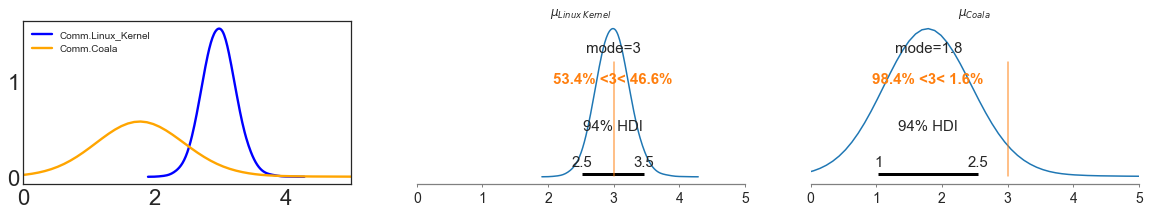

In [97]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3))
[pm.plot_kde(t_v33['mu'][:,comm_to_code(df2,n)], 
                 plot_kwargs={'color': c}, cumulative=False,
                 ax=ax1,
                 label=n) 
      for (c,n) in zip(['blue','orange'],['Comm.Linux_Kernel','Comm.Coala'])]
ax1.set_xlim(0,5)
pm.plot_posterior(t_v33['mu'][:,comm_to_code(df2,'Comm.Linux_Kernel')],ax=ax2,ref_val=3,point_estimate='mode')
ax2.set_title('$\mu_{\mathit{Linux \; Kernel}}$')
ax2.set_xlim(0,5)
pm.plot_posterior(t_v33['mu'][:,comm_to_code(df2,'Comm.Coala')],ax=ax3,ref_val=3,point_estimate='mode')
ax3.set_title('$\mu_{\mathit{Coala}}$')
ax3.set_xlim(0,5)
plt.show()

The distribution of the Coala community clearly shows a more lenient tendency than the Linux Kernel. Though a small portion of the densities overlap in values close to 3, the HDI is clearly below 3---i.e., towards the "agree region" of the scale. On the contrary, the distribution of the Linux Kernel community has all its density concentrated in the interval (2.5,3.5)---in other words, the community's answers are mostly neutral.

Furthermore, we can look at the *difference* of the mean distributions and the *effect size*. When distributions are equal, both the difference of means and effect size are close to zero. In the presence of a difference, the difference of means and effect size distribuions shift towards left or right---depending on the values of the scale. 

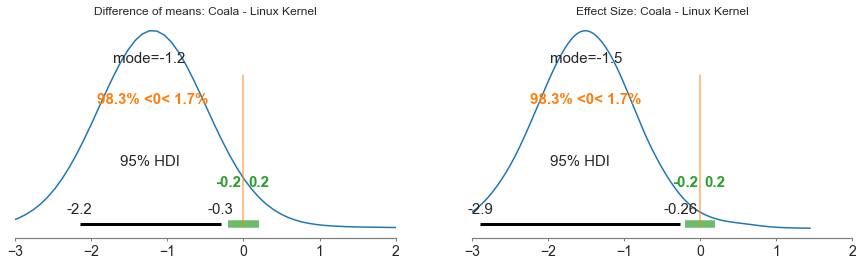

In [113]:
m_lk_v33=t_v33['mu'][:,comm_to_code(df2,'Comm.Linux_Kernel')]
m_c_v33=t_v33['mu'][:,comm_to_code(df2,'Comm.Coala')]
s_lk_v33=t_v33['sigma'][:,comm_to_code(df2,'Comm.Linux_Kernel')]
s_c_v33=t_v33['sigma'][:,comm_to_code(df2,'Comm.Coala')]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))

pm.plot_posterior(m_c_v33-m_lk_v33,ref_val=0,rope=(-.2,.2),point_estimate='mode',hdi_prob=.95,ax=ax1)
ax1.set_xlim(-3,2)
ax1.set_title('Difference of means: Coala - Linux Kernel')

pm.plot_posterior((m_c_v33-m_lk_v33) / np.sqrt((s_lk_v33**2+s_c_v33**2)/2),
                  ref_val=0,rope=(-.2,.2),point_estimate='mode',hdi_prob=.95,ax=ax2)
ax2.set_xlim(-3,2)
ax2.set_title('Effect Size: Coala - Linux Kernel')

plt.show()

These plots also indicate the presence of differences between distributions of answers. Most of the density is located on negative part of the plot. Intuitively, this means that the mean of the answers of the Linux Kernel community are greater than those of the Coala community. Large answer values correspond to the "disagree region" of the scale. Thus, these plots indicate that the Coala community agrees more than the Linux Kernel community to the statement this question poses. In other words, the Coala community is more positive than the Linux Kernel community towards V33.

Note that we have highlighted a *Region Of Practical Equivalence* (ROPE) of (-0.2,0.2). This region marks what values that we consider equal to 0 in practice. The HDI of both the difference of means and the effect size are outside the ROPE. Hence, we can conclude that, **given a ROPE of (-0.2,0.2), there exists a difference between the distributions of the answers of the Coala and Linux Kernel communities**. Note, however, that larger ROPEs would include the HDI, e.g., a rope of (-0.3,0.3). This suggest that, even though there exist a difference, the difference is very small.

In summary, we can conclude that **the Coala community is more lenient than the Linux Kernel community**. That is, the data suggests that **hypothesis H1 is true**.

## References

###### [Kruschke 2015] John Kruschke. Doing Bayesian Data Analysis. 2nd edition. 2015.